In [24]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1233)
tf.random.set_seed(1233)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [25]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [26]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

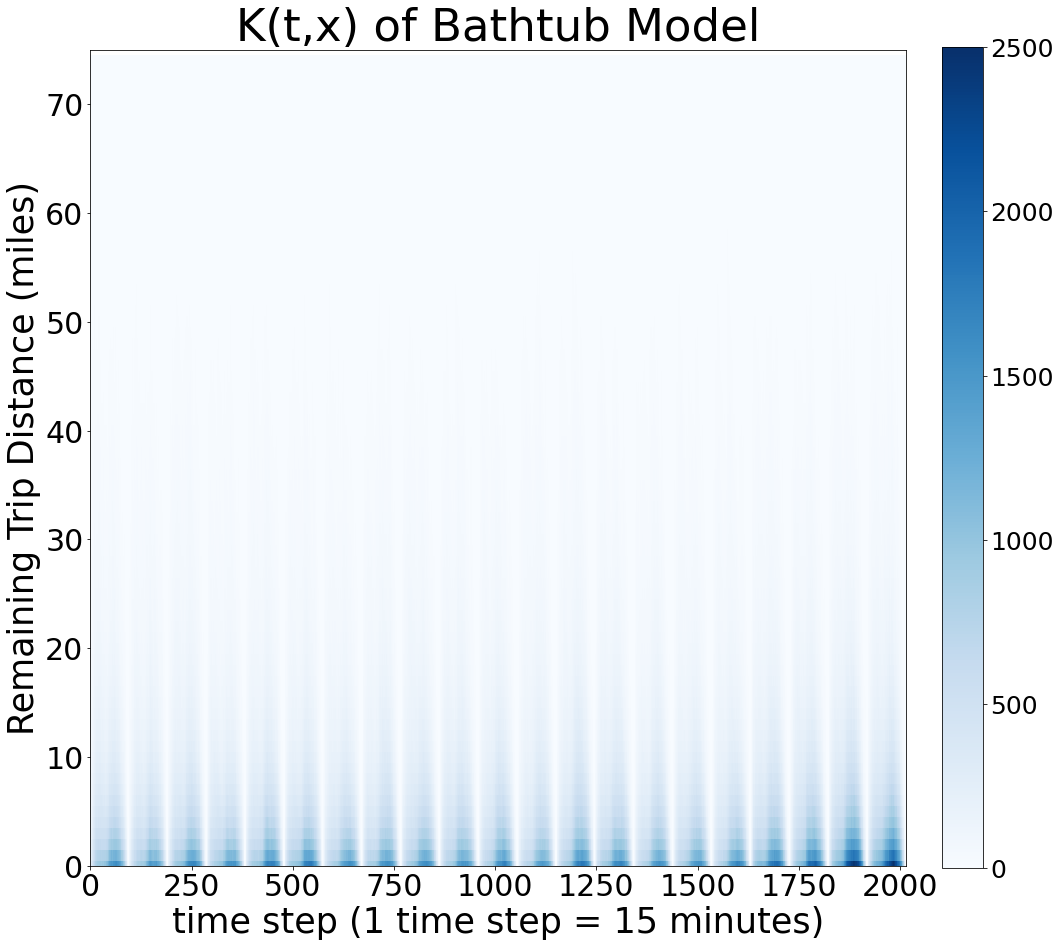

In [27]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [28]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [29]:
Size_diststep = 25 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  6048
N_u =  1209
N_f =  2418


In [30]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [31]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [32]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1233)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [33]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [34]:
X_u_train.shape

(1209, 2)

In [35]:
X_u_test.shape

(4839, 2)

In [36]:
X_u_train

array([[0.33783784, 0.92903226],
       [0.        , 0.95235732],
       [0.33783784, 0.89181141],
       ...,
       [0.        , 0.69330025],
       [0.33783784, 0.6764268 ],
       [0.67567568, 0.3235732 ]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [37]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [38]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.02304536107923005 0.044820460456671721 0.0012702617017883813 0.7699701211413014
0.022053109657300663 0.043325831671692211 0.00078038764290911777 0.7572502645978134
0.017214106677019017 0.031527459148382245 0.0029007542056557877 0.646376564413304
0.014678731087934216 0.025866297947332272 0.0034911642285361598 0.5835415067629328
0.01334015130601973 0.024715010954675647 0.0019652916573638132 0.5652705641162658
0.01308713802331761 0.024280284083974025 0.0018939919626611932 0.5614995836966935
0.013067631997382242 0.024211550750200445 0.001923713244564039 0.5606716058404836
0.012912188696832267 0.02384732580434468 0.0019770515893198534 0.5563358209461423
0.012537966530097705 0.023227730010486589 0.00184820304970882 0.5490850164552996
0.011690945576189403 0.021962417566418622 0.0014194735859601841 0.5342803631168225
0.01154745333089217 0.021826135756476298 0.0012687709053080419 0.5327628384019814
0.011419310972971598 0.021726908505646344 0.0011117134402968526 0.5317892868197126
0.0113572517

0.0082769720082703467 0.01422972387423993 0.0023242201423007629 0.4386680438081606
0.0082741608551255546 0.014195493342156506 0.0023528283680946029 0.43836779913943924
0.0082709929325191691 0.014152818078880558 0.0023891677861577793 0.4379268702500272
0.008267748678052118 0.01412626916477238 0.0024092281913318564 0.4376173553164515
0.0082588525933537382 0.014096432621773311 0.0024212725649341662 0.4373853885605542
0.00825237448486198 0.0140993100639782 0.002405438905745762 0.4374150183554168
0.0082436552885901352 0.014084298567746754 0.0024030120094335173 0.4373844141999116
0.0082388022765928753 0.014107638031886327 0.0023699665212994245 0.4373639883711967
0.00823502976344292 0.014082620877880425 0.0023874386490054141 0.4373177461791471
0.0082325664910172548 0.01407753180969888 0.0023876011723356298 0.4372632825653618
0.0082301989600122721 0.014075669638003292 0.0023847282820212532 0.43719520371697346
0.0082243409248806323 0.01407127474044932 0.0023774071093119438 0.4370484587204381
0.

0.0076725106381630792 0.013693731464303083 0.0016512898120230753 0.43322288733459213
0.0076701371122087445 0.013691975787497491 0.0016482984369199985 0.4332094470047939
0.0076644793901727648 0.013690916471569468 0.0016380423087760609 0.43331748762564587
0.0076594666299400621 0.013685876049370294 0.0016330572105098312 0.43331273765755113
0.0076574652777815569 0.01372928203633185 0.0015856485192312646 0.4339613425524829
0.007654402500844237 0.013704863991299244 0.0016039410103892303 0.4335811525121407
0.0076535861451421409 0.013701452484378335 0.0016057198059059468 0.43352029840551176
0.0076526064123582337 0.013694496477548099 0.001610716347168369 0.4334266287297945
0.0076510620915274516 0.013693981578618333 0.0016081426044365706 0.43344917397217025
0.0076491595584535577 0.013681012071619871 0.0016173070452872452 0.43333545974766075
0.00764618610315097 0.013678368422067631 0.0016140037842343089 0.4332907564598851
0.0076413902774891962 0.013682036883084153 0.0016007436718942399 0.43324662

0.0073842583077812843 0.013599108344437063 0.0011694082711255064 0.4327876284572929
0.0073825273735141951 0.013600230411960835 0.001164824335067556 0.4327913260421519
0.0073805522037713595 0.013599040550692316 0.0011620638568504019 0.43270929721697154
0.0073791981103560229 0.013592927231030184 0.0011654689896818621 0.4326557199938741
0.0073778332750762616 0.013587664541246398 0.001168002008906125 0.43259381553497034
0.0073759770333339369 0.013574484501813682 0.0011774695648541921 0.43248553852182176
0.0073734048894254136 0.013565323311016609 0.0011814864678342191 0.43234821701818077
0.0073717998037065025 0.013558355900492328 0.0011852437069206779 0.43226823253226404
0.0073713267307555352 0.013562976264095984 0.001179677197415087 0.4322808075777541
0.0073711015148801053 0.013566637339353083 0.001175565690407127 0.43234467535889615
0.0073709028045666342 0.013569883133208257 0.001171922475925012 0.43236975157223523
0.0073707222456095654 0.01357272714974722 0.0011687173414719112 0.43237866

0.0073148524530139269 0.01347574430902022 0.0011539605970076331 0.43146992934470096
0.0073148120679295131 0.013477477576194207 0.0011521465596648192 0.43148081083848144
0.00731477173437071 0.013477276544883411 0.0011522669238580104 0.43147431558822424
0.0073146912191245734 0.013476325666795097 0.00115305677145405 0.43145485678228446
0.0073146474181244705 0.013474755065460564 0.0011545397707883767 0.4314369250213945
0.0073145819357216327 0.013473795537944123 0.0011553683334991412 0.43141356599884084
0.0073145184996406768 0.013473246042527439 0.0011557909567539136 0.431407172247238
0.0073143330137781376 0.01346750323211951 0.0011611627954367662 0.43134274366431097
0.0073139058744055765 0.013465051602944205 0.0011627601458669484 0.43130201996666373
0.0073134427844400492 0.013455242696150161 0.0011716428727299383 0.43118648636174356
0.0073131920256420315 0.013451479346352449 0.0011749047049316147 0.4311252775359172
0.0073130031929705581 0.013449785089804754 0.0011762212961363614 0.43108843

0.0072624792046233439 0.013405423911043872 0.0011195344982028157 0.43058534031231843
0.0072623716538792928 0.013407295462675091 0.0011174478450834955 0.4305897055375582
0.007262289449733398 0.013403228005723227 0.0011213508937435682 0.4305641727568899
0.007262201510910676 0.01340318441947312 0.0011212186023482321 0.4305495145775417
0.00726209575667528 0.013402039005319688 0.0011221525080308717 0.4305471067070794
0.0072619815791423268 0.013398859489664107 0.0011251036686205471 0.43053291073169175
0.0072619293303776275 0.013399729679628585 0.0011241289811266702 0.43054600749131233
0.0072618362382606558 0.013399649141657271 0.0011240233348640404 0.4305499493689386
0.0072617352098595725 0.01339876313822381 0.001124707281495335 0.43054219154775697
0.0072615216412325462 0.013397760416880846 0.0011252828655842467 0.43052468758891216
0.007261274346381557 0.01339382449494768 0.0011287241978154329 0.43048173763900066
0.0072610885765388078 0.013390749640896716 0.001131427512180899 0.4304475208722

0.007212599378080985 0.013351360792237857 0.0010738379639241139 0.43029640333741603
0.007211900098209852 0.013348331757292716 0.0010754684391269872 0.43026945466719174
0.0072113247512484886 0.013352029550825302 0.0010706199516716758 0.4302644242525056
0.0072103810869114018 0.013349536234608939 0.0010712259392138643 0.4302293951974811
0.0072086049744957362 0.013345006524820792 0.0010722034241706802 0.43020738001092457
0.0072064572563046748 0.013340611880649432 0.0010723026319599182 0.430138630977881
0.0072046224052836842 0.013343407503679922 0.0010658373068874454 0.4302358181551
0.0072042282703852645 0.013359759854286215 0.0010486966864843143 0.4304275863804738
0.00720369147805757 0.013349070526709764 0.0010583124294053763 0.43035025569136315
0.0072033280300377736 0.013347440614830848 0.0010592154452446993 0.4303210879574723
0.0072030556392457 0.013351623084156976 0.0010544881943344235 0.43033437707052075
0.0072028750757412163 0.013352789326574721 0.0010529608249077113 0.430336861560617

0.0070562145356987431 0.013362667210132207 0.00074976186126527919 0.430289134495466
0.007054014855659904 0.013392666751247756 0.000715362960072052 0.4304847456913114
0.0070500969029255595 0.013393357781085306 0.000706836024765814 0.43050578749894053
0.0070481149978395734 0.013352677444848041 0.00074355255083110628 0.4300452267859924
0.0070456152568436816 0.013359654416527535 0.00073157609715982755 0.43015253761653793
0.00704170678912912 0.013374263572538162 0.00070915000572007825 0.4303078010085724
0.0070368390853591256 0.013365325851066437 0.00070835231965181487 0.43018225823204287
0.0070308254756112059 0.013338402913034482 0.00072324803818792918 0.4299448196351462
0.0070238065879190854 0.013317300035800932 0.00073031314003723811 0.4297720772208081
0.0070198458533362457 0.01329190001814798 0.00074779168852451142 0.42957873142545405
0.0070146170189795591 0.01328279380499868 0.00074644023296043774 0.4296299224771537
0.0070026977334694028 0.013306147380500488 0.0006992480864383186 0.4298

0.0068665889740570224 0.013254713715995205 0.00047846423211883913 0.4295445685319785
0.0068660552475350526 0.013253942659295338 0.00047816783577476666 0.4295877884900773
0.0068657225307301988 0.013254611868011763 0.00047683319344863533 0.4296217895899787
0.0068651069182306314 0.013254318451510946 0.0004758953849503175 0.42963161512446574
0.006863985119802205 0.0132492176753104 0.00047875256429400989 0.42958293305531997
0.0068634008456526134 0.013248811826255447 0.00047798986504977992 0.4295226055080157
0.0068630515072335948 0.013248594609303803 0.00047750840516338686 0.42949974624161896
0.0068625236731759643 0.013240285343235748 0.00048476200311617986 0.4294083410737137
0.006861840605904607 0.013240951056775203 0.00048273015503401 0.4294201568573267
0.0068612162441270361 0.013240486891426711 0.00048194559682736027 0.4293875292213491
0.0068607173449793633 0.013239563789064176 0.00048187090089455104 0.4293634317336339
0.0068605248224050857 0.013239836894433884 0.00048121275037628684 0.42

0.0068437273398191415 0.013245805295384301 0.00044164938425398113 0.42972077118388746
0.0068433920753601992 0.013243635584316002 0.00044314856640439656 0.429733013814993
0.0068432443041730982 0.013242284108770258 0.00044420449957593842 0.42973791203448797
0.0068430120075445326 0.0132385944670566 0.00044742954803246533 0.4297204315886684
0.0068427501408263392 0.013228094423857976 0.00045740585779470227 0.4296389144727319
0.0068424741440270415 0.013238358107113287 0.00044659018094079551 0.42970840003866806
0.0068423970207836795 0.013239921479711463 0.00044487256185589603 0.42968255155319074
0.0068421490325339951 0.013235631096512355 0.00044866696855563578 0.42965610062661985
0.0068421276724391867 0.013235580974444371 0.00044867437043400187 0.4296574643997983
0.0068420695619359961 0.013236826450636764 0.00044731267323522858 0.4296607874271431
0.0068420434335178509 0.013235846561632838 0.00044824030540286275 0.4296526972166041
0.0068420159426568726 0.013234878478424885 0.000449153406888861

0.0068262709791553477 0.013235195351096542 0.00041734660721415382 0.42991583494282687
0.0068261900353008692 0.013235031993421877 0.00041734807717986141 0.42992343493274165
0.0068261252746584285 0.013233505425664311 0.00041874512365254718 0.4299033868831881
0.0068260782138214087 0.013236154781984952 0.00041600164565786511 0.4299272770137565
0.006826048132837657 0.013238186467121478 0.00041390979855383575 0.42994081017793545
0.006826038394950786 0.013238573889056004 0.00041350290084556768 0.42994563851579165
0.0068260232713066244 0.013238539367154453 0.0004135071754587959 0.4299446041989945
0.0068260141369949987 0.01323756656814906 0.00041446170584093673 0.4299388176699938
0.0068260024758154212 0.013236744526734628 0.00041526042489621438 0.4299385762564554
0.0068259916863453955 0.013236711102114202 0.00041527227057658881 0.42993945625206736
0.0068259516193473983 0.013236390772310884 0.0004155124663839126 0.42994084069313293
0.0068258908787781668 0.013237393577298279 0.0004143881802580555

0.0068168518727365875 0.013231081128168051 0.00040262261730512428 0.4298795107455839
0.006816827971592076 0.013230170836972362 0.00040348510621178983 0.4298815162920824
0.00681672423414709 0.013232689223426327 0.00040075924486785417 0.4299031195143194
0.0068165943777392544 0.013234506596614043 0.00039868215886446572 0.42990652981382377
0.0068165150561519481 0.013235627872059055 0.00039740224024484197 0.42992482467718474
0.0068164570190270635 0.01323520804680587 0.00039770599124825697 0.42992537463617564
0.006816344177342607 0.013235283466442331 0.00039740488824288188 0.4299127031503867
0.0068162495290331228 0.013233426248780237 0.00039907280928600864 0.4298899900724403
0.0068161600514381124 0.013233519322889091 0.00039880077998713384 0.42990452691330905
0.0068160325928674735 0.013230748188145729 0.00040131699758921764 0.42986658870902883
0.0068159692093208912 0.013230285543469519 0.00040165287517226339 0.4298848465709744
0.0068158767324018425 0.013231589359965171 0.00040016410483851466

0.0068104654074141752 0.013231438730201304 0.00038949208462704665 0.4300163243738596
0.00681036737879839 0.013232553535545744 0.00038818122205103454 0.4300279357228711
0.0068102313808235653 0.01323412606086595 0.00038633670078118063 0.43001810584223993
0.0068101181010904333 0.013236312076196069 0.00038392412598479731 0.4300204793231951
0.0068099921219446453 0.013234527497042367 0.00038545674684692421 0.4300012621869404
0.00680989737474509 0.013231979627877819 0.00038781512161236093 0.4299594651895761
0.0068098439916767966 0.013230712042176084 0.00038897594117750893 0.42995406889372123
0.0068097473148575789 0.013227120519419568 0.0003923741102955892 0.4299492940861548
0.0068096519155773135 0.013227514193047778 0.00039178963810684853 0.42995466757198
0.0068095700046251432 0.013225909137113098 0.00039323087213718837 0.4299388919927635
0.0068095412993717311 0.013227578570143924 0.00039150402859953765 0.4299577941694804
0.0068094894902830314 0.013227593467962583 0.00039138551260348007 0.429

0.0068040509425326863 0.013227951558765423 0.00038015032629994919 0.4299399764595521
0.0068039503203891089 0.013227363613215685 0.00038053702756253225 0.42992605764194075
0.0068038759185612011 0.013226748188642773 0.00038100364847962838 0.429917066072739
0.006803800122406097 0.013224104081644981 0.00038349616316721275 0.4298893718651572
0.0068037183048860863 0.01322613954889958 0.000381297060872592 0.42988658118043316
0.0068036242956595432 0.013223522455606027 0.0003837261357130591 0.42985767303283523
0.0068035480607502108 0.013223241001678218 0.00038385511982220365 0.42984519525146664
0.0068034566317737577 0.013223200738966273 0.00038371252458124279 0.4298225053470681
0.006803354859011089 0.013224463219810134 0.00038224649821204403 0.4298139694540263
0.0068032442643894383 0.0132242025173632 0.00038228601141567566 0.4298328489732919
0.0068030902731111781 0.013223817354388989 0.00038236319183336688 0.42983791523082454
0.0068029686661874485 0.013224020984455255 0.00038191634791964258 0.4

0.006796701716923384 0.013212244194789731 0.00038115923905703675 0.4297805776001106
0.0067966256845027277 0.013211430695972869 0.00038182067303258648 0.4297813916697523
0.0067965744392968677 0.013211783126724531 0.0003813657518692042 0.4297804826058018
0.0067965681002506032 0.013212580169811748 0.00038055603068945835 0.4297906625908439
0.0067965263445971692 0.013213979214222264 0.00037907347497207405 0.4297915310009735
0.0067964917606374957 0.01321274653903233 0.00038023698224266058 0.4297803281256047
0.0067964645881152868 0.013212306279405742 0.00038062289682483223 0.429774912536046
0.0067964036588079842 0.013211753151169962 0.00038105416644600615 0.42976119873389984
0.0067963728732845924 0.013210212181721564 0.00038253356484762061 0.429737613216212
0.0067963307432745068 0.013211542250125661 0.00038111923642335227 0.42974350020418756
0.00679627795022497 0.013212195357046213 0.0003803605434037255 0.42976231677707016
0.0067962379707920883 0.013211987638515403 0.00038048830306877261 0.42

0.0067923099347275686 0.013209560568579392 0.00037505930087574572 0.42971985675087954
0.006792301098967315 0.013209242672158648 0.00037535952577598262 0.4297152083537096
0.0067922885984490321 0.013209060198597779 0.00037551699830028624 0.42970893098060253
0.0067922847154256484 0.013208642519492731 0.00037592691135856495 0.4297062399996588
0.00679226411146698 0.01320811890912936 0.00037640931380459913 0.4296943018986182
0.0067922345041138274 0.013208167756303575 0.000376301251924079 0.42969539132168977
0.0067922018469396212 0.01320764484290265 0.0003767588509765924 0.42969651840568357
0.0067921776607545621 0.013206493757576649 0.00037786156393247516 0.4296937024767294
0.0067921569630481366 0.01320715233501985 0.00037716159107642239 0.4297030457631851
0.0067921442683940621 0.013207531308135586 0.00037675722865253877 0.429707091752679
0.0067921208641894418 0.01320721090466264 0.0003770308237162431 0.42970681064647637
0.0067920995708898851 0.013208180265626378 0.00037601887615339147 0.4297

0.0067886022731251713 0.0132138686425471 0.0003633359037032411 0.42973216344239884
0.0067885619053901572 0.013213010988005962 0.00036411282277435119 0.42972065706056306
0.0067885145185947477 0.01321173240217936 0.00036529663501013522 0.42969164524106324
0.0067884724516262982 0.013212312829925448 0.00036463207332714838 0.4297020380045608
0.0067884121764986349 0.01321406176969504 0.00036276258330223034 0.4297208321241628
0.0067883867262758541 0.013212128411272254 0.00036464504127945493 0.42970532619904905
0.0067883840614110591 0.013211921788815029 0.00036484633400708891 0.4297005889884429
0.0067883743894098236 0.013211554497418445 0.0003651942814012028 0.4296833637920228
0.0067883233376762912 0.013211598250506345 0.00036504842484623749 0.4296903279274583
0.0067883020716666513 0.013211513921592359 0.00036509022174094379 0.42969299653962395
0.0067882661460565265 0.013211692990303501 0.00036483930180955174 0.42969338590993095
0.0067882388308027532 0.013211383853589099 0.00036509380801640827

0.006785045790726787 0.013202457465393292 0.00036763411606028132 0.4295814623283183
0.0067850350130749283 0.013202351859536833 0.00036771816661302357 0.42958500121791054
0.0067850175534685739 0.013202154636323767 0.000367880470613381 0.42958521572629005
0.0067849958869830168 0.013201365590200118 0.000368626183765916 0.4295839903426313
0.0067849515429452721 0.013199967315464346 0.00036993577042619788 0.42957582348946804
0.0067849252198996686 0.013199005523876518 0.00037084491592281931 0.42957167717194983
0.0067848619271252894 0.013199123633522677 0.000370600220727901 0.4295679794864945
0.0067848257800256478 0.013198527373080773 0.00037112418697052345 0.42954829673146944
0.0067847972689662351 0.013200183671950246 0.00036941086598222373 0.4295520217115888
0.0067847776227294094 0.013199516619431495 0.00037003862602732335 0.42954647273161756
0.0067847577029515379 0.013200468683620683 0.0003690467222823935 0.4295562565924286
0.006784741240018443 0.013201646837283329 0.00036783564275355741 0.

0.0067836334677889064 0.013199179041517335 0.00036808789406047769 0.4295808510587898
0.00678363081275346 0.013199196678913958 0.00036806494659296089 0.4295801970771729
0.006783625718993401 0.013198847837048227 0.0003684036009385743 0.4295736541497493
0.0067836194008595091 0.013198677360921987 0.00036856144079703114 0.42956872943743135
0.0067836141421999951 0.013198332654335005 0.00036889563006498559 0.42957186838583494
0.0067836033602010157 0.013198202092212853 0.00036900462818917861 0.42957506390497696
0.0067835891997864422 0.013198188372976061 0.00036899002659682417 0.4295794476456731
0.0067835788205381818 0.013198597935786278 0.00036855970529008677 0.4295887892272704
0.0067835639355647275 0.013199405994297867 0.00036772187683158797 0.42959897121758733
0.0067835456995175769 0.013199226644624466 0.00036786475441068683 0.4295929263737777
0.0067835277775659475 0.013199016137064382 0.0003680394180675127 0.4295832658566707
0.006783505278320852 0.013198054727889371 0.00036895582875233235 0

0.0067822360995302049 0.013194296271536957 0.00037017592752345305 0.4294660437878252
0.0067822311681396711 0.013193987744345041 0.000370474591934301 0.42946355329571606
0.006782224667265694 0.013193831798241388 0.00037061753629000015 0.4294616010106311
0.0067822103268988677 0.013193328803487636 0.00037109185031009815 0.42945430891526565
0.006782202194096797 0.013193108300943704 0.00037129608724988924 0.4294516326080066
0.00678218583082803 0.013192680175206584 0.00037169148644947646 0.4294443017667002
0.0067821624434301515 0.013192331189294292 0.00037199369756601031 0.42944283612021644
0.0067821303623158344 0.013192961364628978 0.00037129936000269151 0.42944703763625725
0.006782120502794739 0.013193218359981178 0.00037102264560830064 0.4294518082110348
0.0067820872458996938 0.013194047415940213 0.00037012707585917413 0.4294585270486141
0.0067820398431651862 0.013195885201464164 0.000368194484866209 0.4294725950893811
0.0067820079744416572 0.013196120239443708 0.00036789570943960637 0.42

0.0067723824444916566 0.013163075934897284 0.00038168895408602815 0.42928456071573523
0.0067722122104988 0.01316043347151211 0.00038399094948549176 0.4292652288351364
0.0067720977231670344 0.013159924679208878 0.00038427076712518979 0.42927381404115833
0.0067719826668271033 0.013160736889324473 0.00038322844432973419 0.4292513981089614
0.0067719060109608627 0.01315896861332014 0.00038484340860158638 0.4292182263581947
0.0067718343032866285 0.01316038867893711 0.00038327992763614757 0.42922998910816634
0.0067718180377710629 0.013168350945431473 0.00037528513011065261 0.4292833065736139
0.0067717405044268892 0.013161603569375076 0.00038187743947870297 0.4292296605475675
0.0067716958696209025 0.0131611797206079 0.00038221201863390566 0.4292242621618889
0.0067716505739350884 0.013160886176339058 0.00038241497153111877 0.42922047643589906
0.0067715917916596653 0.013160991032288665 0.00038219255103066587 0.42920735314647945
0.00677154400248585 0.0131604843301814 0.00038260367479030021 0.4292

0.0067590863175893438 0.013152501412183383 0.00036567122299530389 0.42915788898742185
0.0067590660345742421 0.013152803928358322 0.00036532814079016294 0.4291628763857441
0.0067590441965246434 0.013152641321910767 0.00036544707113852077 0.42916749849812125
0.0067589738198707864 0.013151996380221371 0.00036595125952020127 0.42917216661602947
0.006758901606508428 0.013150769067554002 0.00036703414546285419 0.42915700952509767
0.0067587985641983615 0.013148351905461441 0.00036924522293528165 0.429120668010106
0.0067587017400087693 0.013147298071824817 0.00037010540819272162 0.4290960516534186
0.0067585628740359583 0.013145056088619361 0.00037206965945255652 0.429067361473042
0.0067584061237787969 0.013141998969287978 0.00037481327826961567 0.42902715050717716
0.0067582856951066183 0.013141956977818748 0.00037461441239448819 0.4290329887869714
0.0067581303997956846 0.013144037508951678 0.00037222329063969116 0.4290480473356217
0.0067578932397595439 0.013148610494844504 0.000367175984674583

0.0067545875494631671 0.013135441385759814 0.00037373371316652004 0.42897224716360155
0.0067545824335237476 0.01313327357395847 0.00037589129308902565 0.4289508309002907
0.0067545633147867061 0.013134558126370389 0.00037456850320302291 0.4289692906330347
0.0067545433977040537 0.013134938683924981 0.0003741481114831267 0.42897387604884263
0.0067545227126086993 0.013134751474128861 0.00037429395108853751 0.42897198560148814
0.0067544863174880537 0.01313496951760465 0.00037400311737145666 0.4289758817135976
0.0067544815478959071 0.013134735769944466 0.00037422732584734849 0.4289755404926371
0.0067544730591689514 0.013133440833292946 0.00037550528504495567 0.4289755850392657
0.006754466156270132 0.013133718196475731 0.00037521411606453289 0.42897345745003157
0.0067544568890596087 0.01313411927219613 0.00037479450592308681 0.4289749691122057
0.006754442434051538 0.013133738252351462 0.00037514661575161433 0.4289690686004488
0.0067544342470486586 0.013133609221945067 0.00037525927215225003 0

0.0067488832261762017 0.01311281042450768 0.00038495602784472278 0.42883749861145515
0.0067488317494671258 0.013114604091000667 0.00038305940793358469 0.4288459300350678
0.0067487583842667266 0.013115867705027465 0.00038164906350598863 0.4288523577700131
0.0067487016718874573 0.013117241769851478 0.00038016157392343683 0.4288607788736144
0.0067486521610094982 0.013117787998712912 0.00037951632330608507 0.4288638360667157
0.00674862056958774 0.013118242551481914 0.00037899858769356614 0.428866226462862
0.006748569923657596 0.013118754707707167 0.00037838513960802541 0.42887337991210434
0.0067485026080762421 0.013118064503564959 0.00037894071258752509 0.42887036737349427
0.0067484757472162128 0.013118793574698284 0.00037815791973414139 0.4288755561618113
0.0067483676181314149 0.013118233774031358 0.00037850146223147239 0.4288792546216945
0.0067482813768316371 0.013116968175793305 0.000379594577869969 0.4288727877490402
0.0067482093792816614 0.01311591658409198 0.00038050217447134331 0.42

0.0067450148148245782 0.013087599683086655 0.00040242994656250122 0.42847772259649747
0.0067449948324589219 0.013087082708373863 0.00040290695654398033 0.4284702154368907
0.0067449689664949124 0.013087230692913662 0.000402707240076163 0.42847513119399827
0.0067449259763889182 0.013088038589592069 0.0004018133631857671 0.4284818711821537
0.0067448770063429945 0.013087999635765742 0.000401754376920248 0.4284900193752023
0.0067448280247309539 0.013088204719228332 0.00040145133023357593 0.4284899595451159
0.00674479290185506 0.013088600028177803 0.00040098577553231645 0.42848942185851674
0.0067447639828976235 0.013088378493744824 0.00040114947205042268 0.4284913100578202
0.0067446911728164718 0.013085731696982603 0.00040365064865034 0.42846453982107413
0.0067446331817350184 0.013085149109598303 0.00040411725387173397 0.42846014083356404
0.0067445915567398455 0.013084585074418415 0.00040459803906127569 0.42846027715902624
0.0067445471867697941 0.013083884995765951 0.0004052093777736365 0.42

0.0067426895155149194 0.013081771085735688 0.00040360794529415063 0.42836115919460893
0.0067426374607221715 0.013081353627018387 0.00040392129442595493 0.4283624901265697
0.0067425588036532915 0.013081280278260783 0.00040383732904580009 0.42837042707061934
0.006742500172217991 0.013079532685374016 0.0004054676590619655 0.42836772069665574
0.0067424589985643464 0.013078779677704187 0.00040613831942450611 0.4283711343436509
0.0067424327079053416 0.013079630950859678 0.00040523446495100622 0.4283860143085872
0.0067423996072210795 0.013080666040462775 0.00040413317397938422 0.4283925654121869
0.00674239179625894 0.013079742017087391 0.00040504157543048953 0.4283842804988046
0.0067423793057421726 0.013080041509191065 0.00040471710229327966 0.42838584912784494
0.0067423728243048561 0.013079972463821029 0.00040477318478868266 0.4283907590163688
0.0067423682595236971 0.013080023440311115 0.00040471307873627874 0.42839296644760777
0.0067423633928538236 0.013078928408312823 0.0004057983773948249

0.0067383169599852938 0.013065819611805151 0.00041081430816543573 0.42828351922963226
0.0067382699310166907 0.013065343328885601 0.00041119653314777935 0.4282741184280139
0.0067382010536906215 0.013066672414049367 0.00040972969333187581 0.4282856218913212
0.0067381043993236566 0.01306807554535634 0.00040813325329097368 0.42829711681754173
0.00673803259543008 0.013068291653260428 0.00040777353759973242 0.42829992634864855
0.0067379664420963463 0.013068231160724784 0.00040770172346790858 0.42830244900613934
0.0067378808223301232 0.013067444838110984 0.00040831680654926248 0.42829896247160104
0.006737789727845324 0.013065481036491111 0.00041009841919953767 0.42829086652085974
0.0067376641441718958 0.013061601688902571 0.00041372659944122073 0.4282770776855729
0.0067375955932299086 0.013060697977501503 0.00041449320895831511 0.4282770769270255
0.0067375025435196445 0.013058809394175941 0.0004161956928633483 0.42827387734135064
0.0067373032203060981 0.013056118979890662 0.000418487460721533

0.0067275838251564185 0.013047322540256104 0.00040784511005673336 0.4282929106246155
0.0067275198225531371 0.013048321807359002 0.00040671783774727256 0.42829418349566944
0.00672747114586521 0.013049789457938997 0.00040515283379142364 0.4282980709753485
0.0067273985586655321 0.013048797754026873 0.00040599936330419065 0.4282978112273485
0.0067273482830681568 0.013049037947432372 0.00040565861870394153 0.42830199458145385
0.006727313771891898 0.013049920915667819 0.0004047066281159777 0.4283066731271223
0.0067273104067891425 0.013050083061589298 0.0004045377519889866 0.428308492862956
0.00672728946319422 0.013049702297546666 0.00040487662884177361 0.42830524027146955
0.0067272695322856254 0.013049457396808573 0.00040508166776267914 0.4283039084669275
0.0067272623559014146 0.013049472485810716 0.00040505222599211341 0.4283106449233516
0.0067272429687630633 0.013050451391656189 0.00040403454586993752 0.4283132379308368
0.0067272381856240161 0.013050792147708157 0.00040368422353987576 0.42

0.0067261535272085393 0.013049398522608719 0.0004029085318083608 0.4282890897084955
0.0067261321498799844 0.013049171337855405 0.00040309296190456438 0.42828858121836905
0.0067261117529542882 0.01304925616620501 0.00040296733970356558 0.42829145459595336
0.006726065618611457 0.013049679391683243 0.00040245184553967047 0.42829321335451526
0.0067260300427609936 0.013049727158292309 0.00040233292722967893 0.4282955160807601
0.0067259879142858546 0.013049731382649709 0.00040224444592199964 0.4282982148289233
0.0067259213034005462 0.013049581591123452 0.0004022610156776404 0.4282988537073471
0.0067258652690731476 0.013048437645513626 0.00040329289263266936 0.4282853407232802
0.0067258527287899867 0.013048313619498951 0.00040339183808102175 0.4282844301268062
0.0067258095359105444 0.013048012349406503 0.00040360672241458544 0.4282833080998234
0.00672578702184845 0.01304718888740178 0.00040438515629511856 0.4282817965604268
0.0067257812019897055 0.013046998886192063 0.00040456351778734711 0.4

0.0067246758364317019 0.013045322903281 0.00040402876958240406 0.4282731211800029
0.0067246653778837776 0.013046365138178027 0.00040296561758952875 0.42827016444806054
0.0067246616320307435 0.013046686713866277 0.00040263655019521 0.4282682965374223
0.0067246588211402961 0.013046779245844617 0.00040253839643597479 0.4282699270867435
0.0067246532072047548 0.01304691650278909 0.00040238991162042012 0.4282719799539647
0.0067246466650813241 0.01304681333698967 0.00040247999317297812 0.4282720528121099
0.006724633447994688 0.013046543940843565 0.00040272295514581026 0.42827267920701584
0.0067246207624712187 0.013045772181449897 0.00040346934349253996 0.4282728649417301
0.006724606988130934 0.013045765500929831 0.00040344847533203636 0.4282757352855017
0.00672459440935661 0.013045741174757194 0.00040344764395602476 0.4282796461231896
0.0067245801775697835 0.013045714287470379 0.00040344606766918759 0.4282869663912201
0.0067245688327172235 0.013046048549515004 0.00040308911591944242 0.4282883

0.0067232693643878129 0.013038095788111936 0.00040844294066369 0.428192754240013
0.0067232661313389 0.013038328024037054 0.0004082042386407459 0.4281884893747396
0.0067232650368426487 0.013038182742097197 0.00040834733158810071 0.42818741638169466
0.0067232611207528672 0.013037812147157176 0.00040871009434855822 0.42818840485172677
0.0067232581435716365 0.01303777804638938 0.000408738240753893 0.42818899676969263
0.0067232520647479465 0.013037804023696507 0.000408700105799387 0.42818973724225845
0.0067232423498968259 0.013037673779111145 0.00040881092068250626 0.4281885326414537
0.00672323585167809 0.013037800005815755 0.00040867169754042634 0.4281878384935551
0.0067232235871681947 0.013037836937084407 0.0004086102372519819 0.42818680721313945
0.0067232033641796678 0.013037497935968766 0.00040890879239056975 0.42818429322700957
0.0067231965879262553 0.013037345832508641 0.00040904734334387021 0.4281841146852575
0.0067231747063028644 0.01303683835139996 0.00040951106120576934 0.42818406

0.0067201927796778759 0.01301347437718548 0.00042691118217027206 0.42798932312612087
0.0067201541229958868 0.013012277261413472 0.00042803098457830217 0.42798701129523614
0.0067200965382844917 0.013010851894641923 0.00042934118192705916 0.4279847140254583
0.0067200560178701206 0.013009179724890362 0.00043093231084987831 0.42797919062965023
0.0067199972148163133 0.013007318055028458 0.00043267637460416936 0.4279797348653112
0.0067199404897377215 0.013006551234387227 0.00043332974508821594 0.42798168598057884
0.0067198280019362634 0.013008733856694132 0.00043092214717839396 0.42798255541887203
0.0067197585725777987 0.013007524100488332 0.00043199304466726412 0.4279657325285676
0.006719606672609249 0.013006988484501755 0.00043222486071674255 0.4279607928300445
0.0067194123377865853 0.013005901691895159 0.00043292298367801049 0.4279472383249507
0.0067193004082958235 0.01300551698941175 0.0004330838271798974 0.4279380417022651
0.0067192559710592351 0.013004541788475576 0.0004339701536428932

0.006714550116315424 0.012995758997586194 0.0004333412350446547 0.42788318674276565
0.006714516089604214 0.012995701059659243 0.00043333111954918437 0.42788596671748536
0.006714441002273407 0.01299640636983697 0.000432475634709844 0.42789964089343563
0.0067144164731159084 0.012997043725654871 0.0004317892205769466 0.4279056317794431
0.0067143607463988932 0.012996451486600048 0.00043227000619773873 0.42789712163110827
0.006714341071712036 0.012995497597002066 0.00043318454642200669 0.4278856315384516
0.0067142935133096627 0.012996238451944826 0.00043234857467450036 0.42788450415029644
0.0067142721212065928 0.012996370112566996 0.00043217412984618969 0.42788556851138426
0.0067142523666613363 0.012996589493510374 0.00043191523981229844 0.42788990463953586
0.0067142285229166059 0.012996855964625388 0.00043160108120782312 0.4278852619462945
0.0067142146577030383 0.012996650844908707 0.00043177847049736959 0.4278851626292685
0.0067141977157044322 0.012997070255969374 0.00043132517543949028 0

0.0067127205813218641 0.012992016470171123 0.0004334246924726051 0.42778029811689294
0.00671270556385443 0.012991144111832527 0.00043426701587633319 0.42777864217063727
0.0067126890339824531 0.012990510284630871 0.00043486778333403492 0.42777330675426034
0.0067126608689240608 0.012990666453439471 0.00043465528440865043 0.4277708703800785
0.0067126452536777782 0.012990411904578123 0.00043487860277743276 0.42776614940743174
0.0067126373102922507 0.012990418973809858 0.00043485564677464469 0.42776452934024867
0.0067126299721624975 0.012990417514671395 0.00043484242965360047 0.4277653043637315
0.0067126253406846921 0.012990246221179372 0.00043500446019001257 0.4277657069730425
0.0067126201441981038 0.012990749116434486 0.00043449117196172064 0.42777025696034593
0.0067126167121542351 0.012991063945834935 0.00043416947847353465 0.4277707061436641
0.0067126095267950785 0.012991002655243219 0.00043421639834693749 0.4277686377958451
0.006712604857896552 0.012990810340904732 0.000434399374888372

0.00671190491808757 0.012988195292697281 0.00043561454347785925 0.4277573897958298
0.0067118853884597113 0.012988060497010769 0.0004357102799086547 0.4277587500905243
0.0067118053768258938 0.012987377387535897 0.00043623336611588978 0.42777032514973423
0.0067117804769626817 0.012986148655382852 0.00043741229854251258 0.42778203754683586
0.0067117646264101428 0.012985349299505478 0.00043817995331480759 0.4277794713467076
0.0067117583442865055 0.01298532527409996 0.00043819141447305093 0.4277782404713738
0.00671174145672273 0.012986700514357212 0.000436782399088249 0.4277819924258238
0.0067117268661636793 0.01298818682418041 0.00043526690814694839 0.4277874187940166
0.0067117197415516644 0.012988948905412533 0.00043449057769079591 0.4277920430226907
0.006711717120203819 0.012988872271029798 0.00043456196937783975 0.4277917698244814
0.0067117131163331647 0.012988491529626143 0.0004349347030401859 0.42778995109816453
0.0067117103578356848 0.012988425708018557 0.00043499500765281223 0.42779

0.006710429756573019 0.012985009096616469 0.00043585041652956957 0.427795622839969
0.006710401312452199 0.012984434601171392 0.00043636802373300663 0.4277829018360955
0.0067103437162774832 0.012982620866965538 0.0004380665655894284 0.42776507128201424
0.0067103059722361837 0.012982140289798633 0.00043847165467373461 0.4277572029856943
0.0067102609970979389 0.012981877996280394 0.00043864399791548284 0.427752465859083
0.00671022573486961 0.012982573145015334 0.00043787832472388569 0.42775243018947434
0.0067102045424268656 0.012982521355510595 0.00043788772934313616 0.4277547720238935
0.0067101833893437081 0.012982458142394121 0.00043790863629329532 0.42775492547064736
0.00671014936781771 0.012982056855459872 0.00043824188017554846 0.4277535746163628
0.00671011703667096 0.012982907164158243 0.00043732690918367738 0.42775754264122684
0.0067101028468358132 0.012982967300910381 0.00043723839276124573 0.42775684884206017
0.0067100865974346908 0.012983436146596855 0.00043673704827252696 0.427

0.0067056795781491223 0.01296507121937027 0.00044628793692797462 0.42759453924085306
0.0067056377620584723 0.012964613780609945 0.00044666174350700038 0.4275966236571528
0.0067056167336626326 0.012963692102426042 0.00044754136489922296 0.42758984393441324
0.0067055893745694489 0.012962304258880739 0.00044887449025815882 0.4275850540030067
0.0067055709391388475 0.012962708909509638 0.00044843296876805803 0.42758798492836303
0.006705555545982525 0.012962782015867277 0.00044832907609777323 0.4275900271225803
0.0067055266822185888 0.012962000300312193 0.00044905306412498363 0.4275929447847281
0.0067055015584849128 0.012961559058102902 0.00044944405886692383 0.4275984440030595
0.0067054807716192578 0.0129620167200359 0.000448944823202615 0.4275989656875747
0.0067054728090115753 0.012962158159307078 0.00044878745871607378 0.42759694017324734
0.0067054610040667689 0.01296241382360851 0.00044850818452502782 0.42759286227723875
0.006705448829984393 0.012962651750109036 0.00044824590985975075 0.

0.0067047393842214545 0.012955855566008556 0.00045362320243435205 0.4275134632879703
0.0067047322824842432 0.012956297829258268 0.00045316673571021835 0.42751611670008627
0.0067047287937114413 0.012956204775003756 0.00045325281241912635 0.42751897432924457
0.0067047273067766455 0.012955466213222409 0.00045398840033088206 0.4275123330404361
0.0067047230924357449 0.012955782198144914 0.00045366398672657527 0.4275167741686424
0.0067047201920498456 0.012955919712876357 0.000453520671223335 0.42752016466602105
0.006704715919021477 0.012955768857452686 0.00045366298059026683 0.4275222901581716
0.0067047122806264533 0.012955446826590569 0.0004539777346623379 0.42752070907198164
0.0067047067289236779 0.012955139600297875 0.00045427385754948118 0.4275198229887628
0.006704700575929967 0.012954530547546509 0.00045487060431342592 0.4275166909549073
0.0067046864323636914 0.012953607744843788 0.00045576511988359541 0.4275074599370392
0.0067046664401326107 0.012951855546437629 0.00045747733382759228 

0.0067040092316143557 0.012950234166532381 0.00045778429669633008 0.42743438324732197
0.0067040048018596936 0.012950016474447533 0.00045799312927185393 0.4274325869582895
0.0067040021927530146 0.012949792515710644 0.00045821186979538489 0.4274343666448239
0.0067039948777942223 0.012949570419454107 0.000458419336134338 0.4274339727303906
0.006703991352204901 0.012949170898477223 0.000458811805932579 0.4274293095970117
0.0067039864008209349 0.012948984938397875 0.00045898786324399425 0.42742777807725674
0.0067039784991848733 0.012948614812975129 0.00045934218539461763 0.42742299641492243
0.006703974862119942 0.012948068423883248 0.0004598813003566356 0.427418053545407
0.00670396916651931 0.012948372763438347 0.00045956556960027428 0.427418200657836
0.0067039668274895166 0.012948577825892899 0.00045935582908613454 0.42741738229386544
0.0067039654194398024 0.012948542837299088 0.00045938800158051754 0.42741560091408093
0.0067039631732419688 0.012948395354479478 0.00045953099200445882 0.427

0.0067037060956387437 0.012952163988933521 0.00045524820234396678 0.4274680174647539
0.0067037020944093655 0.012952509311858254 0.00045489487696047718 0.4274700329985594
0.0067036997559759811 0.012953025727657176 0.00045437378429478645 0.4274733056753815
0.00670369760357764 0.012953839209181287 0.000453555997973993 0.42747628044550556
0.0067036968411305908 0.012953824850276524 0.0004535688319846588 0.42747561247045074
0.006703696351479614 0.01295366641820047 0.00045372628475875781 0.427472478537139
0.0067036939423248927 0.012953576574065593 0.00045381131058419241 0.4274711986897859
0.0067036924073192528 0.012953859094236379 0.0004535257204021266 0.427473180113827
0.0067036898208709195 0.012954147262652614 0.00045323237908922504 0.4274745210315662
0.0067036857181899693 0.012954666810748383 0.00045270462563155493 0.4274768904821153
0.0067036826444938045 0.012954745767341562 0.00045261952164604632 0.42747730481417706
0.0067036805096709695 0.012954819937172412 0.00045254108216952784 0.4274

0.006703395826464874 0.012954465537223073 0.00045232611570667424 0.4274896477938406
0.0067033936988686775 0.012954465892405462 0.0004523215053318927 0.42749042221958367
0.0067033899723037719 0.012954452761455277 0.00045232718315226628 0.4274922070886842
0.0067033878246538512 0.012954188697316026 0.00045258695199167618 0.42749246273806557
0.0067033861381994844 0.012954061594695398 0.00045271068170357011 0.4274903200157701
0.0067033851722955607 0.01295405612962355 0.000452714214967571 0.4274902675225273
0.0067033823602269185 0.012954431420868965 0.00045233329958487228 0.4274903574509412
0.0067033793885672311 0.012954370397334937 0.00045238837979952469 0.4274866465291238
0.0067033756903572732 0.012953926949746791 0.00045282443096775541 0.42748196601307936
0.0067033733860068041 0.012953631081140695 0.00045311569087291278 0.4274789214646309
0.0067033721878622995 0.012953489239684441 0.00045325513604015772 0.4274789694250795
0.006703370390977524 0.0129533277469485 0.00045341303500654785 0.42

0.0067030920135530987 0.012953629385769912 0.00045255464133628478 0.42748842261126646
0.0067030878278439253 0.012953914487668633 0.00045226116801921738 0.42749104934190835
0.006703083362280822 0.012954532854509234 0.00045163387005241103 0.4274951618953936
0.0067030793357316367 0.012954687987644759 0.00045147068381851417 0.4274955013514912
0.00670307481917107 0.012954499197797328 0.00045165044054481244 0.42749400915122787
0.0067030716483622473 0.012954301450676123 0.00045184184604837114 0.42749142548902536
0.0067030616035043573 0.012954295603776547 0.00045182760323216829 0.4274914599098464
0.0067030524472971066 0.012954557770528893 0.00045154712406532058 0.42749472875126754
0.0067030457054773453 0.012954658523030812 0.00045143288792387807 0.4274963423157334
0.0067030405205383021 0.012954895471907542 0.0004511855691690629 0.4275003169132999
0.0067030329529230168 0.012955366183634961 0.00045069972221107256 0.42750785955056697
0.006703028925408647 0.012955628697534966 0.0004504291532823284

0.0067025390467652908 0.012953379893363372 0.00045169820016720925 0.4275123054493632
0.00670253120676533 0.012952709710876439 0.00045235270265422148 0.4275106987588693
0.0067025233473101227 0.012951936864831873 0.00045310982978837255 0.4275073676608892
0.0067025129097211091 0.0129514953882321 0.00045353043121011813 0.4275099361987616
0.0067025011446981194 0.012950830161667882 0.00045417212772835575 0.4275164151573404
0.0067024870729539528 0.012950556239350814 0.00045441790655709126 0.42751669488147515
0.0067024747650268274 0.012951120746747617 0.00045382878330603769 0.42751712493451716
0.0067024665521125577 0.012951183184737454 0.0004537499194876615 0.42751759281780727
0.006702451760159941 0.012951469003522439 0.00045343451679744231 0.42752399547003417
0.0067024393042229256 0.012952053524729787 0.00045282508371606453 0.4275289717444954
0.0067024372596250874 0.012952139808443116 0.00045273471080705936 0.4275297979380436
0.0067024295688478544 0.012952080682875006 0.00045277845482070294 0

0.0067014371447900577 0.012952387449503997 0.00045048684007611885 0.4276050338482873
0.006701421158502331 0.012951995184465773 0.00045084713253888914 0.42760363290679515
0.0067014095189098554 0.012952406928822203 0.00045041210899750739 0.4276069818334438
0.0067014029522521543 0.012953556003569615 0.00044924990093469456 0.4276148640111173
0.0067013916489624941 0.012953893879307997 0.00044888941861699085 0.4276154821286684
0.0067013800781908911 0.01295341040388337 0.00044934975249841312 0.42761396731676377
0.00670135699212731 0.012952727282315569 0.00044998670193905141 0.42761170574837437
0.0067013505821837205 0.012952660877119554 0.00045004028724788668 0.42761207983900207
0.0067013389388085078 0.012953080906647676 0.00044959697096934022 0.4276166272878459
0.0067013307677500234 0.012953164368817759 0.00044949716668228851 0.4276175338348798
0.0067013091334459981 0.012953672983362433 0.00044894528352956367 0.42762576495756877
0.0067012997904220967 0.012954371163527979 0.0004482284173162151

0.0066988416209413908 0.012950552977149764 0.0004471302647330178 0.4276037668027921
0.0066987599761705006 0.0129504130208557 0.00044710693148530188 0.4276047300578865
0.0066987277869623883 0.012950576696408851 0.00044687887751592554 0.42760583129469054
0.0066986400236276134 0.012949745862548784 0.00044753418470644228 0.4276082191887541
0.0066985590145672768 0.012947660737442752 0.00044945729169180158 0.4276042726084687
0.0066985056826315507 0.012947814930434232 0.00044919643482886959 0.4276019786598343
0.0066984168570432667 0.012950344194135379 0.00044648951995115521 0.42760452095909046
0.0066983493060024258 0.012951094806152972 0.00044560380585187957 0.4276076698259681
0.0066982838799039711 0.012951136631838946 0.00044543112796899557 0.4276025801222819
0.0066982064767597852 0.012952034121318812 0.00044437883220075893 0.4275962306724004
0.0066980987578892171 0.012954226706787163 0.00044197080899127075 0.4276017778457757
0.0066980390321600839 0.012954668111587953 0.0004414099527322152 0

0.0066919938085100881 0.012939332448941569 0.00044465516807860753 0.4275475863128362
0.0066919661031300147 0.012938201306727303 0.00044573089953272622 0.4275462368531113
0.0066919300538691683 0.012938726007616369 0.0004451341001219676 0.42755047174526095
0.0066918913684513286 0.012939075682294635 0.0004447070546080219 0.4275509969864486
0.006691830623921341 0.012940290072616222 0.00044337117522645929 0.4275556545499846
0.0066917431015504659 0.01294085910044835 0.00044262710265258231 0.4275480794647032
0.0066917023565682965 0.012942180509292057 0.00044122420384453629 0.4275531090323087
0.006691685479362104 0.012942232504839942 0.00044113845388426626 0.42755379828100337
0.0066916389382335583 0.012941439944271079 0.00044183793219603731 0.4275478358090114
0.0066916085396904858 0.012941742572480814 0.00044147450690015875 0.42754317104296435
0.0066915853540305383 0.012943196160738463 0.00043997454732261376 0.4275447004499945
0.0066915506794848955 0.012942691161865003 0.00044041019710478786 0

0.006689220295860763 0.012930260672431205 0.000448179919290321 0.42743137407924375
0.0066892036072084783 0.012930420768894649 0.00044798644552230686 0.4274347323572082
0.0066891845189893922 0.012929562558024335 0.000448806479954449 0.42743286012792375
0.0066891736508456747 0.012929205131669818 0.00044914217002153155 0.42743017236050806
0.0066891541816024433 0.012929225648735672 0.0004490827144692153 0.4274207515242111
0.00668915018729265 0.012928913135806233 0.0004493872387790673 0.42741300685754385
0.00668914291626069 0.012928876083481455 0.00044940974903992514 0.4274119238083013
0.0066891383073567987 0.012929235401636154 0.00044904121307744291 0.42741322449105557
0.0066891304871758619 0.012929548549605202 0.00044871242474652157 0.4274101936975186
0.0066891239706500768 0.012929635184803934 0.00044861275649621943 0.4274096443845218
0.0066891158391002856 0.012929544120280429 0.00044868755792014245 0.42740875826020336
0.0066891062414960248 0.012929287595808876 0.0004489248871831747 0.427

0.0066886974286660579 0.012927738010442044 0.00044965684689007157 0.4274371334679717
0.0066886934858371759 0.012927724912580155 0.00044966205909419593 0.4274400208532899
0.0066886909576341271 0.012927920597219679 0.00044946131804857534 0.42744258722948575
0.0066886861178761343 0.012928504341414123 0.00044886789433814476 0.42744752796205926
0.0066886846044082555 0.012928625563292152 0.00044874364552435921 0.4274484708390406
0.0066886795191985707 0.012928883350932044 0.000448475687465098 0.4274498281514004
0.00668867550163211 0.012928925601309415 0.00044842540195480464 0.42744928472018684
0.0066886733774912414 0.01292877496520319 0.0004485717897792917 0.4274481031724293
0.0066886725696662453 0.012928579580634191 0.000448765558698299 0.42744798152219
0.006688670184303129 0.012928314787196978 0.00044902558140928143 0.4274472675870936
0.0066886686990966435 0.012928458241807541 0.00044887915638574491 0.4274481132402403
0.0066886664408805935 0.012928693942333059 0.00044863893942812888 0.42744

0.006687671370277452 0.012938388434766782 0.00043695430578812164 0.42749566971178843
0.0066876580497229089 0.012939363867722957 0.00043595223172286174 0.4274980143907086
0.00668764433909681 0.012939797895536054 0.00043549078265756605 0.4274984717616969
0.0066876274259163445 0.012939883548418244 0.0004353713034144446 0.4274975550168155
0.006687614626511483 0.012939427825051137 0.00043580142797182935 0.42749225543301606
0.0066876013135444 0.012938279050799372 0.00043692357628942756 0.4274848994057186
0.0066875840430092115 0.012937132778866278 0.00043803530715214544 0.42747551791000976
0.0066875649812047555 0.01293627125912437 0.00043885870328514071 0.42746821352554076
0.0066875515182577379 0.012935880722330432 0.00043922231418504443 0.4274664231355423
0.0066875287255729592 0.012934685836205384 0.00044037161494053442 0.42745850535504637
0.0066875095451122144 0.012935182460939287 0.0004398366292851415 0.42746694642364585
0.0066874870537737205 0.012935303661715896 0.00043967044583154429 0.4

0.0066872380999297076 0.012935533876401705 0.00043894232345770956 0.4274774424330693
0.0066872378763926923 0.012935539570903622 0.00043893618188176178 0.42747766358866435
0.006687237324362297 0.012935581626346502 0.00043889302237809242 0.42747794274176354
0.0066872350394253377 0.012935763039196418 0.00043870703965425784 0.4274795206137333
0.0066872335741345488 0.012935864828501625 0.00043860231976747288 0.4274805272638707
0.006687230411952883 0.012935970057328839 0.00043849076657692692 0.4274811913638242
0.0066872253819635387 0.012935943925020102 0.00043850683890697575 0.4274804565963195
0.0066872228551873936 0.012935904800059763 0.0004385409103150246 0.4274798308144386
0.0066872185870149011 0.012935741007368252 0.0004386961666615502 0.42747684098691685
0.0066872177569347931 0.01293575792832038 0.00043867758554920689 0.4274762408397501
0.0066872169504644556 0.012935728068606536 0.00043870583232237515 0.42747521869727684
0.0066872156343304829 0.012935805916176768 0.00043862535248419715 

0.0066860755454248707 0.012933566724022731 0.00043858436682701072 0.4274935177342939
0.0066860632461111583 0.012932161443818089 0.00043996504840422654 0.42748425715685373
0.0066860571968707207 0.012930954439427347 0.00044115995431409514 0.4274792561760215
0.0066860443258575947 0.012931293829418083 0.00044079482229710757 0.4274792009136882
0.0066860383483847464 0.01293189509861639 0.00044018159815310289 0.42748009114891855
0.006686026674849764 0.012932519335222114 0.000439534014477414 0.4274836710052605
0.00668601468732975 0.01293266304007239 0.00043936633458710922 0.4274858989724773
0.00668600504599783 0.012933631870498789 0.00043837822149687006 0.42749338043443486
0.0066859991084107792 0.012933086259854374 0.00043891195696718469 0.42749380875525855
0.0066859960153253942 0.012932687720318751 0.00043930431033203834 0.42749235448730827
0.0066859924704551427 0.012932717367312547 0.00043926757359773959 0.42749193066253655
0.0066859880964414281 0.012932521055224688 0.00043945513765816758 0.

0.0066848010762232037 0.012938498832837474 0.00043110331960893384 0.427537150747284
0.006684785470920925 0.012938475063428212 0.00043109587841363837 0.4275368847731619
0.00668477204780075 0.012937964744466646 0.00043157935113485364 0.42753238767865825
0.0066847512115800764 0.012936810754137365 0.00043269166902278674 0.42752442537869845
0.00668473056075037 0.012936194070456498 0.00043326705104424043 0.4275179281410553
0.0066847160160003688 0.012935636981365541 0.00043379505063519596 0.42751350868091514
0.0066847080097641662 0.01293600238650155 0.00043341363302678226 0.42751448946787396
0.0066847020389631685 0.012936184880371061 0.00043321919755527562 0.4275143351378706
0.00668469617200954 0.012936044597397816 0.00043334774662126378 0.42751437095162126
0.0066846915342606283 0.012936066597538596 0.00043331647098266091 0.4275134069155023
0.0066846868743273532 0.012936159808165043 0.0004332139404896639 0.4275142295019934
0.0066846803132774336 0.01293642005769962 0.00043294056885524734 0.427

0.0066843187341583659 0.01293520997540421 0.00043342749291252146 0.4274754274863184
0.0066843091468610071 0.012934932060435755 0.00043368623328625882 0.4274780207514361
0.0066843021043755026 0.012934363757830553 0.00043424045092045345 0.42747599958595195
0.0066842964964613887 0.012934364965328484 0.0004342280275942937 0.427475674645117
0.0066842936173439641 0.012934840588316983 0.00043374664637094585 0.42747523900700884
0.0066842875375862929 0.012934680931322978 0.00043389414384960783 0.42747699096403713
0.0066842861088651662 0.012934721626230534 0.000433850591499798 0.42747518785988753
0.0066842829246509822 0.012934728738822815 0.0004338371104791502 0.42748057429988895
0.0066842784288809673 0.012934924275474904 0.00043363258228703108 0.42748263648213836
0.0066842736003781562 0.012935272423389398 0.00043327477736691518 0.42748719755280234
0.0066842693162251828 0.01293616840885 0.000432370223600366 0.4274923904637546
0.0066842679293328457 0.012935733207015306 0.00043280265165038587 0.42

0.00668406988118124 0.012934738665048382 0.00043340109731409714 0.4274907703415925
0.0066840666376101442 0.01293484976056582 0.00043328351465446777 0.427493745727106
0.0066840621319624264 0.012935034000412429 0.00043309026351242506 0.4274968540579013
0.0066840591765647056 0.012935175047332317 0.00043294330579709395 0.4274987271285828
0.0066840562237007791 0.012935003700113221 0.00043310874728833606 0.4274976991817578
0.0066840527383909432 0.012934781033800948 0.00043332444298093932 0.42749637412129843
0.0066840511024719978 0.012934570832513769 0.00043353137243022665 0.4274939964413211
0.006684048215057645 0.012934544264705085 0.00043355216541020411 0.42749215753297404
0.0066840457185552227 0.01293466325167834 0.00043342818543210578 0.42749345235474284
0.0066840436759297616 0.012934987125136931 0.00043310022672259237 0.4274964113678813
0.0066840411064857715 0.012935349634947054 0.00043273257802449 0.4274982076213287
0.0066840393286445934 0.012935253462258389 0.000432825195030799 0.42749

0.0066831498047298958 0.012931464093824428 0.00043483551563536335 0.42753043601388035
0.0066831400631707141 0.012930812749359944 0.0004354673769814848 0.42752959013680136
0.0066831309342540437 0.012929944132904572 0.00043631773560351612 0.42752550012951085
0.0066831272859936893 0.012929358056113161 0.00043689651587421762 0.42752139646294635
0.0066831134531036111 0.012929368363391791 0.00043685854281543131 0.4275213732332298
0.0066830995470511922 0.012929633326622197 0.00043656576748018751 0.42752231071504493
0.0066830906640185928 0.012929557166760844 0.00043662416127634106 0.4275210263835932
0.0066830768209748519 0.012929462576579712 0.00043669106536999252 0.42751870222398836
0.006683067877091658 0.012929391040296076 0.00043674471388723967 0.42751582404086746
0.0066830428350372114 0.012929075894426234 0.00043700977564818791 0.4275143561937958
0.0066830157544864625 0.012928597116308449 0.00043743439266447667 0.4275160711515913
0.0066830019315903336 0.012928146645766888 0.000437857217413

0.0066795995450443955 0.01292308755366601 0.00043611153642278091 0.42741292791702684
0.0066795796269078942 0.012921982349675036 0.0004371769041407524 0.42739640677239965
0.0066794922790391117 0.012920456298060963 0.0004385282600172601 0.42737385542988887
0.0066794062078678954 0.01292178921292266 0.00043702320281313145 0.42738593792629015
0.0066793489560848405 0.012921817728675632 0.00043688018349404917 0.4273939342827334
0.0066792625693385954 0.012922597006221635 0.00043592813245555534 0.4273953563727388
0.0066792279348522766 0.012922380690814134 0.00043607517889041953 0.42739122024188264
0.0066792060808093974 0.012921963945776707 0.00043644821584208735 0.4273846635563999
0.0066791831466372171 0.012919517676912178 0.00043884861636225733 0.4273482019349553
0.0066791755210035492 0.012919637114186391 0.00043871392782070744 0.4273427179895057
0.0066791443155958859 0.012920918755973643 0.00043736987521812812 0.4273570177900104
0.0066791312193937328 0.012920926987733282 0.0004373354510541848

0.0066740873610419615 0.012899414051512393 0.00044876067057153025 0.4272908830016414
0.0066740491009773988 0.012900172881461183 0.00044792532049361359 0.42730431184022993
0.0066739991230354888 0.012900050851093936 0.00044794739497704182 0.42730558928399204
0.00667392960347774 0.012900093484166384 0.00044776572278909727 0.4273021283578975
0.0066739254304917194 0.012900620008697312 0.00044723085228612678 0.42730440785376306
0.0066739055447941455 0.012901256083711579 0.00044655500587671124 0.42731259837492386
0.0066738705984294832 0.012901551423811781 0.00044618977304718507 0.4273169877388474
0.0066738415104304616 0.012901852829016352 0.00044583019184457167 0.42731854509979694
0.0066738194643035063 0.012902020931977074 0.00044561799662993823 0.42732190407612763
0.0066737940691083911 0.012901811662626094 0.00044577647559068938 0.4273247233996135
0.0066737681035378815 0.012901479841586511 0.00044605636548925107 0.42732425222324844
0.0066737348747713619 0.01290105069650937 0.0004464190530333

0.0066723088034712765 0.012898988595609616 0.0004456290113329371 0.42725906949980197
0.0066722910991206721 0.012899319709786954 0.000445262488454389 0.4272672563040869
0.0066722724226297731 0.012899720602703509 0.00044482424255603734 0.4272672848811301
0.0066722420974803911 0.01290053487599668 0.00044394931896410308 0.4272664465126603
0.00667219388544697 0.012903304707422942 0.00044108306347099782 0.4272646201072887
0.0066721871884589832 0.012903393390684926 0.0004409809862330406 0.42726417867416233
0.0066721520522002725 0.01290241579444234 0.00044188830995820378 0.42725939616858244
0.0066721364038906947 0.012902086782929797 0.00044218602485159182 0.4272712383595577
0.0066720845542105967 0.012901063315516281 0.00044310579290491269 0.4272746096656457
0.0066720565607700554 0.012901193449271374 0.00044291967226873683 0.4272768088617838
0.0066720410781354721 0.012901139620404557 0.00044294253586638825 0.4272761678884038
0.00667200695448897 0.012900275119231043 0.00044373878974689792 0.4272

0.0066705276252808348 0.012903304381384208 0.00043775086917746193 0.42731297031281534
0.0066705238142660611 0.012903798408597941 0.00043724921993418161 0.4273147763902712
0.0066705156703879363 0.012903799399566348 0.0004372319412095253 0.4273185016347427
0.0066705081622570094 0.012903465599234845 0.00043755072527917286 0.427319744387744
0.0066705080712197006 0.01290348402697057 0.00043753211546883162 0.4273181483932365
0.0066705030256747882 0.012903158722931976 0.00043784732841760008 0.42731972947325053
0.0066704980447725116 0.0129029145611006 0.000438081528444423 0.4273193964047303
0.0066704908843914761 0.012902892237197205 0.00043808953158574679 0.42731961607806523
0.0066704867332993932 0.012902707843096523 0.00043826562350226335 0.42731781247708406
0.006670485544747768 0.012902557448947078 0.0004384136405484581 0.42731606781228876
0.0066704798866495177 0.012902649464356481 0.00043831030894255375 0.4273144572530463
0.0066704759883883186 0.012902636558336684 0.00043831541843995277 0.4

0.0066696705485249815 0.012900654887953777 0.00043868620909618517 0.4272671471311517
0.0066696603619534368 0.012900948055163097 0.00043837266874377658 0.4272696227078815
0.0066696469471639649 0.012900848603446634 0.00043844529088129532 0.42726866397751123
0.0066696393574475609 0.012901183699534483 0.00043809501536063914 0.42726735111131064
0.00666962345531761 0.012901354176122032 0.0004378927345131891 0.4272691046393345
0.0066696135743735162 0.012901811400442931 0.00043741574830410046 0.42727286723692365
0.0066696028622015889 0.01290169467244698 0.00043751105195619729 0.4272711363898977
0.0066695889536970742 0.01290184529208052 0.00043733261531362912 0.4272686031063153
0.006669569410181716 0.012902087861579876 0.00043705095878355529 0.42727031902216717
0.0066695606001722077 0.012902235219959679 0.00043688598038473745 0.42727005669943785
0.0066695561830694078 0.012902545175324453 0.00043656719081436378 0.4272704308864628
0.0066695423282964609 0.012902878986346665 0.0004362056702462559 0

0.0066667496285603735 0.012896599301565578 0.00043689995555516926 0.4272255231469301
0.006666720588039186 0.012896057023322464 0.000437384152755908 0.4272199579930711
0.0066667077368262675 0.012894686489579237 0.000438728984073298 0.427215296345598
0.0066667005442330677 0.012895058803629905 0.000438342284836231 0.42722059378749444
0.0066666947204198227 0.012895185193497865 0.00043820424734178018 0.42722271880072765
0.0066666729954704433 0.012895562268005936 0.00043778372293494988 0.4272286205049321
0.006666640596603512 0.012896619581510548 0.00043666161169647686 0.42723619603857393
0.0066666326654159242 0.012896727071585895 0.00043653825924595336 0.4272361030292179
0.0066666137249758077 0.012896434725467707 0.00043679272448390947 0.4272318800822542
0.0066666016471366293 0.012896876666286316 0.00043632662798694284 0.42723173307387946
0.0066665844981485074 0.012897501925817045 0.00043566707047996961 0.4272313430239116
0.0066665801903201876 0.012897230911021351 0.00043592946961902389 0.42

0.0066663085253709032 0.012896989778324638 0.000435627272417168 0.4272416099195685
0.0066663079729598349 0.012896837393980561 0.000435778551939109 0.4272454750510857
0.0066663069386949493 0.012896997407736336 0.00043561646965356235 0.4272453044194065
0.0066663065570366862 0.012897118904082473 0.00043549420999089953 0.4272446598196831
0.0066663060800386149 0.01289730165154165 0.00043531050853557948 0.42724615593278253
0.0066663057413555 0.01289742799748279 0.00043518348522820984 0.4272480025471158
0.0066663055912538583 0.012897500441990058 0.00043511074051765864 0.4272482891980149
0.00666630513275842 0.01289753881143146 0.00043507145408537947 0.4272496052717497
0.0066663049240580606 0.012897534160275123 0.00043507568784099737 0.42725013934960676
0.0066663042174454554 0.012897562652248114 0.00043504578264279579 0.42725111739639193
0.0066663038474280688 0.012897569841884216 0.00043503785297192236 0.42725106654824696
0.0066663036804325282 0.012897546420748135 0.00043506094011692113 0.42724

0.0066660658668638486 0.012896802732979457 0.00043532900074824032 0.42725718615033215
0.0066660642059430094 0.012896713294226146 0.00043541511765987233 0.4272574914007675
0.0066660623844446822 0.012896746003218024 0.00043537876567134034 0.42726006558747637
0.0066660593588650473 0.012896884406327056 0.00043523431140303915 0.42726255876666375
0.0066660530319282473 0.012897723092901632 0.00043438297095486277 0.4272716934299469
0.0066660504372677712 0.012897943258343177 0.00043415761619236483 0.42727426261925416
0.0066660477116656219 0.012897771454075916 0.00043432396925532739 0.4272741946876356
0.0066660434778134468 0.012897759150860688 0.00043432780476620553 0.4272737745717914
0.006666043033516404 0.012897868081638626 0.00043421798539418176 0.4272749115592924
0.006666038811622592 0.012897877425860804 0.00043420019738438085 0.4272748427530538
0.0066660375657652217 0.012898108846765391 0.00043396628476505196 0.42727413388587204
0.0066660345236360906 0.012897647803377715 0.00043442124389446

0.0066659527756945834 0.012898941912669076 0.0004329636387200897 0.4272784408561511
0.0066659515469941191 0.012898873884494273 0.00043302920949396507 0.4272779432046702
0.0066659464496227252 0.012898509587189513 0.00043338331205593688 0.4272780148476181
0.006665940990628132 0.012898264295597164 0.00043361768565909918 0.427279938185878
0.0066659403533927183 0.012898464788767142 0.00043341591801829477 0.42728291685228603
0.0066659317575363764 0.012899656640010538 0.00043220687506221396 0.42729130234802354
0.0066659290936887218 0.012899623704370309 0.00043223448300713405 0.4272892389600517
0.0066659237060315108 0.012899091019484344 0.00043275639257867743 0.42729024872734717
0.0066659180194294752 0.012899535311752881 0.00043230072710607017 0.42729326962906966
0.00666591624117836 0.012899691691093142 0.00043214079126357763 0.42729628555249793
0.0066659061850727862 0.012900895125098861 0.00043091724504671177 0.4273042563239628
0.0066659035820229818 0.012900919774130694 0.00043088738991527034

0.0066648137253473849 0.012900857769968854 0.00042876968072591592 0.427348080389614
0.00666480984198862 0.01290070799202345 0.00042891169195379025 0.4273458740535641
0.0066648046810337536 0.012900310146602562 0.00042929921546494619 0.42734253861849997
0.0066648009822228311 0.012900100481927858 0.00042950148251780419 0.4273430284655724
0.0066647965186850894 0.012900030595210332 0.00042956244215984637 0.4273468901419318
0.0066647908665161742 0.012899885494109555 0.00042969623892279331 0.4273496558743626
0.0066647896163515618 0.01290018536616914 0.00042939386653398294 0.4273529028867868
0.0066647800926474682 0.012899995684989635 0.00042956450030530029 0.4273563772830285
0.006664768646976453 0.012899713038508457 0.0004298242554444491 0.4273572795259567
0.0066647563765582975 0.012899421904832786 0.00043009084828380951 0.42735748909044996
0.0066647349186585046 0.012899655475499717 0.00042981436181729156 0.4273569995294313
0.00666467043640391 0.012901117171702734 0.00042822370110508624 0.4273

0.0066633639830771989 0.012890423713667566 0.00043630425248683189 0.42720184243622433
0.0066633460775536116 0.012890184545192092 0.000436507609915132 0.4272012901227524
0.0066633085836604591 0.01289000138686904 0.00043661578045187756 0.4271977015847452
0.0066632558171120394 0.012890513167287893 0.0004359984669361866 0.42719588635847394
0.0066631991108813985 0.012891692036100041 0.00043470618566275533 0.4271848634465087
0.0066631591977181917 0.01289284191203641 0.00043347648339997388 0.42718604484278644
0.0066631396522912438 0.012893388660902047 0.00043289064368044018 0.4271881240534865
0.0066631149893009167 0.012893496409095264 0.00043273356950656987 0.42718991270096124
0.0066630915568695525 0.012893259987719993 0.00043292312601911256 0.4271929448206706
0.0066630821780467647 0.012892836921903749 0.00043332743418978011 0.427188017317045
0.0066630788088882726 0.012893114351455747 0.00043304326632079748 0.4271923215328655
0.0066630728966560141 0.012893044245770561 0.00043310154754146787 0

0.0066617870616500425 0.012884934648009631 0.00043863947529045326 0.4271779880173949
0.0066617712593657237 0.012885271016082779 0.00043827150264866841 0.4271827469448798
0.0066617573520667333 0.012885348644879309 0.000438166059254157 0.42718933827007405
0.0066617528903093505 0.012885256196057824 0.000438249584560877 0.42719175076161414
0.0066617469054419676 0.01288516190046057 0.00043833191042336476 0.4271918249339526
0.0066617407715599871 0.012885432504740628 0.00043804903837934623 0.42719252737405183
0.0066617333652492575 0.01288574365186502 0.000437723078633494 0.4271908590274399
0.0066617260630931893 0.0128862174173714 0.00043723470881497806 0.4271931094673124
0.0066617134494806451 0.01288702493798048 0.00043640196098080952 0.42719639095129597
0.00666170791641559 0.01288713055093409 0.00043628528189708989 0.4271968963212863
0.0066616977583204605 0.012887274962997254 0.00043612055364366717 0.4271954884328037
0.0066616847668481017 0.012886966293545193 0.00043640324015100957 0.4271903

0.0066606968979700905 0.012883991935285303 0.0004374018606548785 0.4271739271317772
0.0066606942419456024 0.012884130773958643 0.00043725770993256291 0.4271778067744319
0.0066606931543224486 0.012884137077399898 0.00043724923124499973 0.42717823001629723
0.0066606918119665806 0.012884026938191561 0.00043735668574159964 0.42717756233280696
0.0066606904970234661 0.01288377919319943 0.00043760180084750157 0.4271756347937082
0.006660689663857214 0.012883781450888076 0.00043759787682635297 0.4271739883981193
0.0066606884160963281 0.012883515482635938 0.00043786134955671772 0.42717168750125656
0.0066606870522512747 0.012883441242790278 0.00043793286171227053 0.427170896583914
0.0066606854560908417 0.0128834507720241 0.00043792014015758379 0.42717071689449543
0.0066606848584423468 0.01288383129755064 0.00043753841933405246 0.4271737011714605
0.0066606833310098677 0.012883683264684845 0.00043768339733489005 0.42717207264979623
0.006660682677860962 0.012883648583236202 0.00043771677248572241 0.

0.0066602615228757139 0.012883091563318346 0.00043743148243308188 0.42717700423207944
0.006660247937517105 0.012883388293853264 0.0004371075811809469 0.42717468292396304
0.0066602398840295719 0.012883310660381389 0.00043716910767775517 0.42717198475402257
0.00666022470772055 0.012882859272830186 0.0004375901426109142 0.42716869579122113
0.0066602098969391977 0.012882823076971684 0.00043759671690671114 0.42716871547056107
0.0066601979500657028 0.012882117841742575 0.00043827805838882986 0.42716579880898764
0.0066601816734337821 0.01288205063635103 0.00043831271051653417 0.4271667277997135
0.0066601722049782642 0.012882132251105035 0.00043821215885149326 0.4271663912500749
0.006660150653159184 0.012883861773142038 0.00043643953317633 0.4271770643301899
0.0066601454674748957 0.012884221554176937 0.00043606938077285512 0.4271835518631707
0.0066601148424608771 0.012883797148076821 0.00043643253684493428 0.4271793589904836
0.0066600880505871523 0.012884048334938997 0.00043612776623530754 0.4

0.0066589574613912846 0.01287798855275026 0.00043992637003230952 0.4270882375415614
0.006658944524027148 0.012878332519669503 0.000439556528384794 0.4270944470044809
0.00665892854794748 0.012878236658579841 0.00043962043731511727 0.42709457969231185
0.006658920544571803 0.012878200959887431 0.00043964012925617508 0.42709468988463606
0.0066589045729939641 0.012878447642561451 0.00043936150342647735 0.4270985440637396
0.0066588853031242746 0.012878622423742894 0.00043914818250565435 0.4270990918369971
0.0066588710034906941 0.012878821747842583 0.00043892025913880469 0.42710174216751523
0.0066588433643389516 0.012880385161651043 0.00043730156702686081 0.4271114956058738
0.00665882027844509 0.012881677128125468 0.00043596342876471258 0.42712303720750183
0.0066588032996044138 0.01288278964235025 0.00043481695685857705 0.42713864766645493
0.0066587613355178644 0.012883216904373425 0.0004343057666623038 0.4271453791066298
0.0066587361806309062 0.012881617671650846 0.00043585468961096621 0.427

0.0066576974667081051 0.012881081386713143 0.00043431354670306712 0.427147602750973
0.0066576907862922379 0.012881459046010174 0.00043392252657430103 0.4271520325787166
0.0066576882880038084 0.012881424556172267 0.00043395201983535 0.4271502784436511
0.0066576864495780661 0.012881538387342434 0.00043383451181369876 0.4271515268718816
0.0066576846459667173 0.012881550619694183 0.00043381867223925128 0.427153301391403
0.00665768387115849 0.012881440754687773 0.00043392698762920661 0.427154099782682
0.006657682720507237 0.012881310045910959 0.00043405539510351537 0.42715303177434794
0.00665768114981627 0.012881407787846006 0.00043395451178653433 0.42715320646370025
0.006657678778691627 0.012881563903920656 0.00043379365346259797 0.4271540662072109
0.0066576774226531623 0.012881508954567201 0.00043384589073912404 0.4271534171459709
0.0066576755987015649 0.01288127926258566 0.00043407193481746976 0.42715216980976584
0.0066576741033604024 0.012881110847775767 0.00043423735894503827 0.4271506

0.0066571890195868009 0.012878295981362033 0.0004360820578115693 0.4271529228002013
0.0066571826784837616 0.012878956373194634 0.000435408983772889 0.4271553914296159
0.0066571795947736817 0.012878860515788281 0.00043549867375908215 0.42715413737338187
0.0066571751106742376 0.012878979323172472 0.00043537089817600403 0.42715493620364736
0.0066571728468602723 0.012879043162889996 0.00043530253083054872 0.4271563159596634
0.0066571689373045159 0.012879275692251047 0.00043506218235798505 0.4271551080929034
0.0066571650242245655 0.012879582407737674 0.00043474764071145685 0.4271532814556499
0.0066571613149099349 0.012879803821586412 0.00043451880823345716 0.4271516961660852
0.0066571540281693282 0.012880022528643939 0.00043428552769471683 0.42714832705907435
0.006657150511522973 0.012879733071409891 0.00043456795163605573 0.42714278823084106
0.0066571420205514568 0.012879814458074864 0.00043446958302804987 0.4271421657578607
0.0066571341007219814 0.012879993460636445 0.00043427474080751734

0.0066567019963085609 0.012875107088750453 0.0004382969038666693 0.427129938505441
0.0066566935118003842 0.012874756474203624 0.00043863054939714536 0.42713038453948465
0.006656684810538523 0.012874984510214947 0.0004383851108620993 0.42713112372687245
0.0066566803811998494 0.012875001343559542 0.00043835941884015704 0.42713154967628325
0.0066566756997359306 0.012875210865521215 0.00043814053395064531 0.42713358421799347
0.0066566731860594483 0.012875354953568161 0.00043799141855073578 0.42713487182204785
0.0066566662968143443 0.012875580516582625 0.00043775207704606269 0.42713731493265045
0.00665665686817383 0.012875720406395324 0.00043759332995233662 0.42714038369777146
0.0066566536919761615 0.012875664132831146 0.00043764325112117695 0.42714150977807075
0.0066566476212850528 0.012875307179641231 0.00043798806292887397 0.4271441717666902
0.00665664330909722 0.012875256865648698 0.00043802975254574305 0.42714486731871687
0.0066566393433997615 0.012875370976589038 0.0004379077102104850

0.0066564841367070552 0.012876860817888639 0.00043610745552547181 0.42715929987443285
0.0066564786189971621 0.012876974950365546 0.00043598228762877845 0.42716159428043804
0.006656475631095009 0.012877132453864702 0.0004358188083253159 0.42716342595848394
0.00665647055234873 0.012877246981702249 0.00043569412299521133 0.4271662857996503
0.0066564694494356718 0.012877228324800637 0.00043571057407070619 0.4271667391220975
0.00665646590365448 0.012877288252283429 0.00043564355502553057 0.4271675318104357
0.0066564637410157189 0.012877421087121831 0.00043550639490960637 0.42716772532867886
0.0066564629398585913 0.012877341769610284 0.00043558411010689776 0.4271654560901649
0.0066564619897280164 0.012877308148086904 0.00043561583136912842 0.4271654214284824
0.0066564616009046869 0.012877338680594139 0.0004355845212152354 0.42716713938694145
0.0066564608823525551 0.012877011707395936 0.00043591005730917359 0.4271669201538462
0.0066564601101999042 0.012877125213107361 0.00043579500729244654 0

0.0066562978540705168 0.012878470459358872 0.00043412524878216142 0.42716609754447155
0.0066562959208546889 0.012877970450881581 0.00043462139082779639 0.42716256804084507
0.0066562938888269519 0.012877966229050186 0.00043462154860371687 0.4271625785820648
0.0066562925446821131 0.012878170130722132 0.00043441495864209381 0.4271636214282001
0.0066562921311351091 0.012878253414392324 0.00043433084787789541 0.4271637753437229
0.0066562914540610855 0.012878237488926487 0.00043434541919568477 0.42716193814783454
0.0066562910322202047 0.01287817038430525 0.00043441168013515972 0.4271611508051408
0.0066562907680442042 0.01287809669458684 0.00043448484150156852 0.4271610820821435
0.0066562905219235352 0.012878060635187372 0.00043452040865969813 0.4271609331725152
0.0066562901264384791 0.01287805528840736 0.0004345249644695976 0.42716153570155035
0.0066562897418677471 0.012878069646457841 0.00043450983727765283 0.42716259642750093
0.0066562897192840266 0.012878059267907072 0.0004345201706609803

0.0066551467919199452 0.012879899223512995 0.000430394360326896 0.42724604994158416
0.0066551229018373395 0.012881350521590213 0.00042889528208446559 0.4272485271585697
0.0066551177611296414 0.012881808041626369 0.00042842748063291356 0.42724958908712546
0.0066550886569626735 0.012881189870423608 0.00042898744350173992 0.42724597775818457
0.006655073516010546 0.012880934847696113 0.00042921218432497921 0.42724571766066666
0.0066550431902023637 0.012880814840245546 0.00042927154015918187 0.42724871880656806
0.0066550194390875986 0.0128817811390508 0.00042825773912439692 0.4272555728223264
0.0066549955263459316 0.012882163563808084 0.00042782748888377909 0.42725767656287555
0.0066549766894046106 0.012883432407580329 0.00042652097122889153 0.42726431665134057
0.0066549718507128673 0.012884572952889924 0.00042537074853581152 0.42726792974935374
0.0066549580897036593 0.012883703788331027 0.00042621239107629112 0.42726186263478605
0.0066549498826861449 0.01288328054710002 0.00042661921827226

0.0066538573634166232 0.012871624038352309 0.00043609068848093744 0.4272166264378187
0.0066538498549028463 0.012872180655477908 0.00043551905432778336 0.42721880891428665
0.0066538415654710491 0.012872764335339284 0.00043491879560281324 0.42722187672544387
0.0066538339179787378 0.012872752388143749 0.00043491544781372606 0.42722433769511575
0.0066538219626587286 0.012872489570000461 0.00043515435531699625 0.42722440849997506
0.0066538081465898668 0.01287227075958221 0.00043534553359752409 0.42722493317911253
0.0066538025262231548 0.012871998570679787 0.00043560648176652251 0.427224398771681
0.0066537945132836129 0.012872100347273456 0.00043548867929377064 0.4272240320309844
0.0066537912343249336 0.012872442957818997 0.00043513951083086922 0.4272249713483955
0.006653786833405965 0.012872712057316681 0.00043486160949524912 0.42722508006592813
0.0066537815139130459 0.012872805201237209 0.0004347578265888833 0.4272232640131905
0.0066537773412714144 0.012872876708739704 0.000434677973803125

0.0066516070813578444 0.012863413120100182 0.0004398010426155068 0.4271716789396674
0.0066515928502244607 0.012863130957031343 0.00044005474341757842 0.42716875815266325
0.00665158107562152 0.012862780097974459 0.00044038205326857972 0.4271657816253612
0.006651566665849159 0.012862566441247324 0.00044056689045099455 0.42716643196447
0.0066515542583503225 0.012862006792859896 0.00044110172384074841 0.42716394506208044
0.0066515531951212509 0.012861976335842046 0.00044113005440045671 0.42716399054496873
0.0066515405865873126 0.012861663164625376 0.00044141800854924823 0.427159907275278
0.0066515307455759084 0.012861423675104131 0.0004416378160476853 0.4271568210516237
0.0066515194126227153 0.012861877969628411 0.0004411608556170199 0.4271619992550196
0.0066515145302945217 0.012861663559904779 0.0004413655006842646 0.42715981214201376
0.0066515081888027317 0.012860858035619396 0.00044215834198606691 0.42715283546849603
0.0066514988369569825 0.012860856312365831 0.00044214136154813421 0.42

0.0066506502121811131 0.012867530461760347 0.00043376996260187877 0.42723845466213745
0.0066506487959429525 0.012867360969611268 0.00043393662227463655 0.4272382192644724
0.006650647299006913 0.012867073924254596 0.00043422067375923018 0.42723783349416167
0.006650646599040016 0.012866954919303527 0.00043433827877650539 0.42723722510086953
0.0066506456458449029 0.012866972081362305 0.00043431921032750055 0.4272364924904947
0.0066506449127862848 0.012867046678679675 0.00043424314689289434 0.4272353074158875
0.0066506439679603234 0.012867209268557044 0.0004340786673636026 0.42723566477385716
0.0066506432433758068 0.012867179790374623 0.00043410669637699065 0.42723552983951907
0.0066506412302845229 0.012867132853156195 0.0004341496074128507 0.4272340393974193
0.0066506403511581852 0.012867119118665912 0.0004341615836504579 0.42723352776064427
0.0066506387434527667 0.012867014898049955 0.00043426258885557892 0.4272320526586046
0.006650638106078112 0.012866958169167933 0.00043431804298829077

0.0066504249384689712 0.012868850223197869 0.00043199965374007365 0.4272396435685613
0.0066504218584001263 0.012868642294961067 0.00043220142183918571 0.42723805822491523
0.0066504214619289327 0.012868863910596256 0.00043197901326160918 0.427239941399569
0.0066504188312461257 0.012868488883601613 0.00043234877889063866 0.427236946491263
0.00665041553979123 0.012867912942326296 0.00043291813725616343 0.4272344258784902
0.0066504097372881484 0.012867746334973585 0.00043307313960271244 0.4272334340549427
0.0066504064978303717 0.012867824818177656 0.000432988177483087 0.42723537283460145
0.0066504017790953111 0.012868019823718907 0.00043278373447171506 0.42723683297618525
0.0066503976035874662 0.012867811139985797 0.00043298406718913503 0.42723378391266803
0.0066503940000757359 0.01286742655044191 0.00043336144970956104 0.42723146295592346
0.0066503897772822208 0.012866872844942697 0.00043390670962174474 0.42722637283629306
0.0066503886316164433 0.012866437674390153 0.00043433958884273391 

0.0066499685300803789 0.012863918231295096 0.00043601882886566218 0.42722099757401205
0.006649961094500877 0.01286441807231356 0.00043550411668819326 0.42722559200557775
0.0066499554212114259 0.012864433650544294 0.00043547719187855897 0.42722549326681186
0.0066499507856646574 0.012864310383449812 0.00043559118787950258 0.4272246088801973
0.0066499443622255842 0.012863569739686912 0.00043631898476425554 0.42721761366492284
0.0066499379910327514 0.012863145548661983 0.00043673043340351883 0.4272163588421483
0.0066499362277875384 0.012862805621725133 0.00043706683384994434 0.42721386171703013
0.006649931339087518 0.012863063547886319 0.00043679913028871724 0.4272161906276732
0.0066499279512449326 0.012863283641091162 0.00043657226139870312 0.42721975354783753
0.0066499227276264365 0.01286373831214274 0.00043610714311013282 0.427226805063178
0.0066499171816904535 0.012863998208605006 0.00043583615477590145 0.4272339217298339
0.0066499139563713948 0.012863455677512918 0.0004363722352298706

0.0066494239787537142 0.012865108278721917 0.00043373967878551092 0.4272455262407636
0.0066494210165013255 0.012864895848646593 0.00043394618435605749 0.4272422088537516
0.0066494157146125554 0.012864783627187246 0.00043404780203786474 0.42724265349459833
0.0066494098167175029 0.012864893266841629 0.00043392636659337675 0.4272455615686631
0.0066494005841343283 0.012865041298489937 0.00043375986977872043 0.4272504875203845
0.0066493917871852182 0.012865571834454781 0.00043321173991565552 0.42726189193138236
0.0066493881096675728 0.012865566292076639 0.00043320992725850652 0.4272626596590211
0.0066493783246305369 0.012865455860309931 0.00043330078895114385 0.4272617187250506
0.0066493633612026122 0.012865300132842693 0.00043342658956253187 0.42726033501411476
0.00664935821559106 0.012865739652852296 0.00043297677832982481 0.4272593749409093
0.0066493514757402367 0.01286600827840146 0.00043269467307901425 0.4272634389453795
0.0066493449025978747 0.012866378397798233 0.00043231140739751568

0.0066487649542616226 0.012864655308881033 0.00043287459964221167 0.4272171053583186
0.0066487629333406425 0.012864718576732954 0.00043280728994833049 0.4272170724596479
0.0066487536154670483 0.012865190421904073 0.00043231680903002328 0.42721861997855864
0.0066487386714490651 0.012865725436639353 0.0004317519062587767 0.4272207831030543
0.0066487339156444383 0.01286583575212181 0.00043163207916706639 0.42722135405378203
0.0066487117792303841 0.012865997690644 0.000431425867816767 0.4272231580271656
0.0066486914305211274 0.012866142445536638 0.00043124041550561651 0.42722853272872513
0.0066486845710591845 0.012866198077152051 0.00043117106496631883 0.4272294811804477
0.0066486748855695051 0.012865773179488237 0.00043157659165077305 0.4272263309116016
0.0066486653291288758 0.012866136091765554 0.00043119456649219796 0.42723103209176216
0.0066486555342162267 0.01286642829122577 0.00043088277720668242 0.427236398006674
0.0066486465588895555 0.012866631222561355 0.0004306618952177556 0.427

0.0066481432478718216 0.012869171933245974 0.0004271145624976694 0.427254751892706
0.00664814322307932 0.012869162897031518 0.0004271235491271215 0.4272542533452307
0.0066481429898185458 0.012869165611143383 0.00042712036849370985 0.4272537009946062
0.0066481426678766308 0.012869099508706577 0.00042718582704668446 0.4272525953439818
0.0066481423713182757 0.012869044683578232 0.00042724005905831885 0.4272516891506614
0.0066481420006210589 0.012868905265068719 0.000427378736173399 0.4272506804690439
0.006648141641567463 0.012868855652756942 0.00042742763037798351 0.4272502689925323
0.006648141280584407 0.012868843025463135 0.00042743953570567865 0.4272504673747165
0.00664814089061284 0.012868874361761359 0.00042740741946432068 0.4272509725376126
0.0066481404006230515 0.012868862222665329 0.00042741857858077454 0.42725179091527277
0.006648139836810364 0.012868853200923522 0.00042742647269720566 0.42725210555273313
0.0066481394225029744 0.012868846687104342 0.00042743215790160742 0.4272520

0.0066480419757284541 0.012868403722941242 0.00042768022851566608 0.42724660559107197
0.006648040747186809 0.012868336627434218 0.0004277448669393998 0.42724602405036927
0.0066480385908195619 0.012868161351710152 0.00042791582992897197 0.4272446651505025
0.0066480374771378022 0.012868152503269824 0.00042792245100578 0.4272438114829679
0.006648036879032624 0.012868141745347032 0.00042793201271821516 0.42724388644827355
0.0066480362818279225 0.012868131152127425 0.00042794141152841989 0.427243555793213
0.0066480355955429154 0.012868096080076937 0.00042797511100889325 0.42724331161826734
0.0066480353262747746 0.012868014145412568 0.00042805650713698091 0.4272426244349358
0.006648035078172668 0.012867868670205868 0.0004282014861394693 0.42724241252042505
0.0066480349001897367 0.012867809762615376 0.00042826003776409651 0.4272422547375463
0.0066480346954546406 0.012867758545602197 0.00042831084530708388 0.4272419880579235
0.0066480345330924987 0.012867826030856124 0.0004282430353288738 0.42

0.00664758250863755 0.012870022771588921 0.00042514224568617707 0.4272496858973987
0.0066475720504013142 0.01286966593242782 0.00042547816837480934 0.42723879667227627
0.0066475713046642059 0.012869949684966971 0.00042519292436144125 0.4272387763537995
0.0066475679861671289 0.012869560218406552 0.00042557575392770681 0.42723667113604136
0.0066475604729363718 0.01286984226057266 0.0004252786853000839 0.4272417477059252
0.0066475540041180618 0.012869949904672993 0.00042515810356313032 0.42724050935338775
0.0066475406159764777 0.012870188405092993 0.00042489282685996235 0.4272392123985569
0.00664752092542617 0.012870481062988581 0.0004245607878637587 0.427240365720855
0.0066474909419660475 0.012871230826474934 0.00042375105745716114 0.42724720112107833
0.0066474647447919005 0.012871550487225828 0.00042337900235797236 0.42725195025387513
0.0066474189842835778 0.012872231658985977 0.0004226063095811795 0.4272667142762798
0.00664740864474226 0.012872492850759677 0.00042232443872484374 0.4272

0.0066437732472721328 0.012856199105166 0.00043134738937826585 0.4270698274462817
0.006643751764445106 0.012856191858476524 0.0004313116704136883 0.42706378952876134
0.00664372362005003 0.012856123974278003 0.0004313232658220574 0.4270637203034261
0.0066436788800603181 0.012857337288132866 0.00043002047198777008 0.42708154968464207
0.0066436528286545971 0.01285830026133317 0.00042900539597602475 0.4270860077992804
0.0066436308911632753 0.012859157319998408 0.00042810446232814349 0.4270870228693391
0.0066435946994812829 0.01286034234305162 0.00042684705591094574 0.4270849786155094
0.0066435767834729679 0.012860506922578294 0.00042664664436764169 0.42709115332100994
0.0066435512717396917 0.012860551777092227 0.0004265507663871569 0.4270895611827289
0.006643530838341195 0.012860315695875368 0.00042674598080702107 0.4270739591885507
0.0066435023907188053 0.012860660212648619 0.00042634456878899208 0.4270804243774596
0.0066434610119649809 0.012861738659344651 0.00042518336458531147 0.427093

0.0066415473024323277 0.012854594547052197 0.00042850005781245871 0.4270642521248122
0.0066415390668550008 0.012854201745947275 0.00042887638776272711 0.42706081772716126
0.006641524528627275 0.012853596043763993 0.0004294530134905573 0.42705490350030234
0.0066415051689891289 0.01285346559532138 0.00042954474265687693 0.42705206321476674
0.0066414950933533744 0.012853814817809435 0.0004291753688973138 0.42705303446974263
0.0066414858324924751 0.012854039631021193 0.00042893203396375724 0.42705586128822204
0.0066414786454704455 0.012854314193256224 0.00042864309768466757 0.4270594405421147
0.006641470316199184 0.012855396907844362 0.0004275437245540054 0.4270684742793832
0.0066414681358590195 0.012855046420821473 0.00042788985089656489 0.4270690552039674
0.0066414641299776412 0.012855309348048851 0.00042761891190643117 0.4270660925316765
0.0066414473728548494 0.012854753601744427 0.000428141143965272 0.4270614649705697
0.0066414269627108622 0.012853812630140621 0.00042904129528110275 0.

0.00664092957462069 0.012856673420378932 0.00042518572886244768 0.42706886919148107
0.0066409258617980572 0.012856780387701224 0.000425071335894891 0.4270691917652033
0.0066409235115737521 0.012856971231247287 0.00042487579190021707 0.42706863884114493
0.0066409220716958086 0.012856948906798858 0.00042489523659275895 0.4270676246611427
0.0066409207131847992 0.01285688297004969 0.00042495845631990782 0.4270670513788343
0.0066409176135753013 0.012856674728986299 0.00042516049816430397 0.42706832851909676
0.0066409144646542764 0.012856475209685886 0.00042535371962266734 0.427065922281912
0.0066409113753198327 0.012856425606109591 0.00042539714453007432 0.4270642716856396
0.0066409070198131552 0.012856323948414844 0.00042549009121146573 0.4270613606608892
0.0066409029005044676 0.012856495524801375 0.00042531027620755989 0.42706082598644535
0.0066409016706070953 0.012856569564492116 0.00042523377672207355 0.42706078114301993
0.0066409000295799244 0.012856812955003797 0.00042498710415605123 

0.0066407789492724965 0.012854931205179679 0.00042662669336531345 0.4270483082732319
0.0066407751490825482 0.012855031806953585 0.00042651849121151127 0.4270476231455298
0.0066407730373773408 0.012854984079357415 0.00042656199539726678 0.427047638451071
0.0066407695771302667 0.012854935738920941 0.00042660341533959123 0.4270487398665999
0.0066407615956415207 0.012854953197471802 0.00042656999381124035 0.42705171540080755
0.0066407574524424305 0.012855058291779303 0.00042645661310555794 0.4270534893603472
0.0066407443253069312 0.012855379423623827 0.00042610922699003526 0.4270603072012759
0.0066407416535884476 0.012855522177276479 0.00042596112990041582 0.4270617157086029
0.0066407329046415083 0.012856289205359653 0.00042517660392336459 0.4270667931262128
0.0066407275948517537 0.012856748012053455 0.00042470717765005208 0.4270627497257194
0.0066407251120614982 0.012856883150545246 0.00042456707357775038 0.42706127501024915
0.0066407201546264559 0.012856874933449903 0.0004245653758030086

0.0066403857679201159 0.012857264602762085 0.00042350693307814614 0.4270757793758875
0.006640380459184447 0.01285737938326908 0.00042338153509981436 0.42708295471764635
0.0066403729106793248 0.012857831744508717 0.00042291407684993249 0.42708837683514106
0.0066403661058014353 0.012857759627756303 0.00042297258384656737 0.4270859889976529
0.0066403588167005759 0.012857527787129329 0.00042318984627182272 0.4270744905420697
0.0066403541674299391 0.012857605163970861 0.00042310317088901743 0.4270773032338984
0.0066403500474678115 0.012857823821266568 0.00042287627366905588 0.42708070049801666
0.0066403454418370329 0.012858103184524123 0.00042258769914994235 0.42708344041158086
0.0066403399849494652 0.012858065769740128 0.00042261420015880205 0.4270817789188126
0.00664033297726939 0.01285770046670886 0.00042296548782991896 0.42707619127609286
0.00664032664565677 0.01285716829745797 0.00042348499385556828 0.4270702136642941
0.0066403218746196885 0.012856918635256205 0.00042372511398317252 0.

0.0066397764848827789 0.01285184581793964 0.00042770715182591674 0.4270042317074588
0.0066397706349772823 0.012851760795496023 0.0004277804744585419 0.4270021111825995
0.0066397658781099586 0.012851673919471396 0.00042785783674852222 0.4270008188508997
0.0066397595929856782 0.012851634751946511 0.00042788443402484581 0.4269996677061027
0.0066397533924835326 0.012851780254407662 0.00042772653055940372 0.4269996213877735
0.0066397507913832782 0.012851526240275529 0.00042797534249102809 0.426996375615023
0.0066397485005127667 0.012851439174702026 0.00042805782632350655 0.4269953430446048
0.0066397449581561971 0.012851647066748281 0.0004278428495641128 0.4269973409038566
0.0066397395392045252 0.012851911392328358 0.00042756768608069281 0.42699969161783957
0.0066397368713875136 0.012851746459496495 0.0004277272832785318 0.42700144616772034
0.0066397347895936565 0.012851290087866276 0.00042817949132103588 0.4270006521216098
0.0066397324406371229 0.012851287886713619 0.00042817699456062743 0.

0.0066396129836374558 0.012850172530000795 0.000429053437274116 0.42697858327134247
0.0066396110274615132 0.012850045514640366 0.00042917654028266087 0.42697668863458665
0.0066396094032350533 0.012850107731637143 0.00042911107483296321 0.42697707549656627
0.0066396077017901326 0.012850074724639003 0.00042914067894126313 0.4269753430220892
0.0066396059759547092 0.012850017699473205 0.00042919425243621314 0.4269728962117407
0.0066396048401882665 0.012850088175241931 0.00042912150513460106 0.4269727371578501
0.0066396032192561237 0.012849899122274343 0.00042930731623790411 0.42697137327447493
0.0066396024296707891 0.012849838538581156 0.00042936632076042157 0.4269712230195303
0.0066396000787457407 0.012849778186413453 0.00042942197107802738 0.4269731094093232
0.0066395977676003944 0.01284970829542495 0.00042948723977583888 0.42697502395961856
0.0066395966283751681 0.012849570235687733 0.00042962302106260323 0.42697487105364546
0.006639595406122998 0.012849543250151483 0.000429647562094513

0.006639288810717907 0.012846407979694687 0.00043216964174112654 0.4269261682411814
0.0066392858082035856 0.012846264231205056 0.00043230738520211418 0.4269282690878283
0.0066392838858661775 0.012846095011871306 0.0004324727598610482 0.4269299775215993
0.0066392820197315487 0.012846094564429696 0.00043246947503340172 0.42692977045481595
0.0066392800421923442 0.012846265159287325 0.00043229492509736368 0.42692936349369903
0.0066392782887029567 0.012846353294635715 0.00043220328277019824 0.426927575074614
0.0066392757959426573 0.012846464261387563 0.00043208733049775107 0.4269244115361686
0.0066392735056535132 0.012846379329120479 0.00043216768218654804 0.42691969587434603
0.006639271059482991 0.012846429004702179 0.00043211311426380315 0.4269162318971788
0.0066392665013743262 0.012846164820121632 0.00043236818262702004 0.4269165810733696
0.0066392615408914068 0.012845846700043847 0.00043267638173896661 0.42691537866634416
0.0066392548665059493 0.01284554826232309 0.00043296147068880747 

0.0066386319662152648 0.012841470484732685 0.00043579344769784388 0.4268971815063739
0.0066386194315322658 0.012842370376168139 0.00043486848689639238 0.4268957662453907
0.00663861330063442 0.01284218233170252 0.00043504426956631934 0.42689518689290173
0.0066386053200765864 0.012841149360183228 0.00043606127996994378 0.42689632643059927
0.0066385998052549064 0.012840728574748276 0.00043647103576153763 0.42689748971416747
0.00663859311832268 0.01284044472338557 0.00043674151325979007 0.4268954681516914
0.0066385875089196291 0.012840568138940193 0.00043660687889906532 0.4268970097334807
0.0066385819532986641 0.012840631224184872 0.00043653268241245597 0.42690075262918414
0.0066385786453946223 0.012840667620367683 0.00043648967042156183 0.42690450153246956
0.00663857038480547 0.012841188353554302 0.00043595241605663785 0.4269134136494763
0.0066385641528564146 0.012841406158007452 0.00043572214770537607 0.42691577712847434
0.0066385560350407458 0.012841562185212792 0.0004355498848687002 0.

0.0066379671291837859 0.012842971961643019 0.00043296229672455238 0.4268940847888956
0.0066379663623090685 0.012842472630082886 0.00043346009453525082 0.42689197757709885
0.0066379654116057885 0.012842779789395912 0.00043315103381566484 0.42689552296617045
0.0066379627340139805 0.012842844551980198 0.00043308091604776344 0.42689418282119607
0.0066379608330628757 0.012842743201504943 0.00043317846462080796 0.4268915407930081
0.0066379597154366723 0.01284259368983171 0.00043332574104163423 0.4268911676945764
0.0066379581043227651 0.012842618655022609 0.00043329755362292113 0.4268906228025684
0.0066379565282360846 0.012842472961345377 0.00043344009512679164 0.4268899267849075
0.0066379543520305208 0.012842218634101359 0.00043369006995968245 0.42688963672047303
0.0066379522930263574 0.012842052122002715 0.00043385246404999963 0.42688987809750467
0.006637951385217368 0.012841759663907002 0.00043414310652773467 0.4268904908872894
0.0066379489671179164 0.012841953006021964 0.00043394492821386

0.0066375859338424466 0.012846644522234442 0.00042852734545045155 0.4269527240106142
0.006637585163270684 0.012846533187639213 0.00042863713890215475 0.4269516135773783
0.0066375845772910363 0.012846593393093858 0.00042857576148821466 0.4269512710527231
0.0066375838733382878 0.012846779271505068 0.00042838847517150867 0.42695186987202816
0.0066375832026821331 0.012846841344806448 0.00042832506055781811 0.4269521733970514
0.0066375821864903227 0.012846903334960271 0.00042826103802037367 0.4269532099568146
0.00663757927487529 0.012847082838377993 0.00042807571137258696 0.4269571832377287
0.0066375782264177421 0.012847053663037646 0.00042810278979783816 0.42695706744066975
0.0066375777191502883 0.012847096815511681 0.00042805862278889569 0.42695404227540024
0.006637576702985773 0.012847028535261271 0.00042812487071027438 0.4269532464646418
0.0066375752876660209 0.012846799401108767 0.00042835117422327528 0.42695210925428934
0.0066375750826553085 0.012846610262316515 0.000428539902994101 0

0.0066374842066096009 0.012847218699937739 0.00042774971328146362 0.42696008225285337
0.0066374840145624857 0.012847119567342599 0.00042784846178237285 0.42695920660028885
0.0066374838613732692 0.012847037504513182 0.00042793021823335655 0.4269587347271488
0.006637483634778037 0.012846871322311253 0.0004280959472448208 0.4269577297082874
0.0066374834913649709 0.012846828046989729 0.00042813893574021307 0.4269575204010503
0.0066374832343475 0.012846784666953456 0.00042818180174154379 0.42695692229393023
0.00663748300723843 0.012846809667754784 0.00042815634672207516 0.4269568195964778
0.0066374829252305685 0.012846864801090695 0.00042810104937044226 0.42695716882992757
0.0066374828564222717 0.012846920206934941 0.00042804550590960316 0.426957793615327
0.0066374828184115869 0.012846903492335186 0.00042806214448798792 0.42695777308638555
0.006637482797839502 0.012846881901005752 0.00042808369467325187 0.4269576620410345
0.0066374827842665121 0.012846887571395594 0.00042807799713743009 0.4

0.0066374236489647256 0.012846156815663236 0.00042869048226621542 0.4269480632929357
0.00663742143312635 0.012845759070935221 0.00042908379531747895 0.4269457071596088
0.0066374194891435107 0.012845695411990309 0.00042914356629671253 0.4269442795837632
0.0066374172640989645 0.012845694260953014 0.00042914026724491576 0.42694278842923955
0.00663741577575304 0.012845530006490375 0.00042930154501570486 0.42694152095044036
0.0066374133506670483 0.012845130197453579 0.00042969650388051763 0.42693935522616283
0.0066374122099439638 0.012844697972317803 0.00043012644757012405 0.42693841578014147
0.00663741074967905 0.012844721491194519 0.00043010000816358097 0.4269384419348781
0.0066374096280660709 0.012844826490779308 0.00042999276535283387 0.4269389182949222
0.0066374081538987757 0.012844853257335958 0.00042996305046159324 0.4269388124048348
0.0066374069270636526 0.012844931804743618 0.00042988204938368836 0.4269381022465368
0.0066374065857634614 0.012844945137179752 0.00042986803434717145 0

0.0066373464563613286 0.012844907991802858 0.00042978492091979935 0.42693636445733063
0.0066373460273578917 0.012844962433588904 0.00042972962112687856 0.42693564495271213
0.0066373458017265543 0.012844949883107592 0.00042974172034551672 0.4269349733966651
0.006637345528720512 0.012844922906642959 0.00042976815079806595 0.42693466652920903
0.00663734529450644 0.012844848007303913 0.00042984258170896723 0.42693441982981317
0.0066373450294391735 0.012844822709414932 0.000429867349463416 0.42693480481480445
0.0066373445153261011 0.012844799198748032 0.00042988983190416933 0.42693555119911697
0.0066373439058584347 0.012844776502068667 0.00042991130964820356 0.42693610467156196
0.0066373434582173534 0.012844765637406854 0.00042992127902785219 0.4269361838265298
0.0066373422719759557 0.01284475027201719 0.00042993427193472054 0.42693551480532704
0.0066373413416687737 0.012844748734058099 0.00042993394927944896 0.42693466793232665
0.0066373400796709879 0.0128447527028653 0.0004299274564766754

0.00663695816457325 0.0128453400016105 0.00042857632753599969 0.42692933559244023
0.0066369555897228477 0.012845370049985384 0.0004285411294603114 0.426930096887458
0.0066369555015006543 0.012845231053324906 0.00042867994967640371 0.42692996952738216
0.0066369518852957329 0.012845213841553963 0.00042868992903750204 0.4269298961272852
0.0066369486257708363 0.012845255151436408 0.00042864210010526345 0.42693112786290943
0.0066369447499434082 0.012845260016009599 0.00042862948387721833 0.4269305317076183
0.0066369409293244195 0.012845353817094842 0.00042852804155399772 0.4269306616700322
0.0066369353653539511 0.012845345127732855 0.00042852560297504795 0.426928408711063
0.0066369280765353374 0.012845147150610482 0.00042870900246019285 0.4269220207841631
0.0066369261230243438 0.012844898878020782 0.00042895336802790653 0.4269212847329043
0.0066369210511441823 0.01284486748612605 0.00042897461616231474 0.4269207610624906
0.0066369134258475243 0.012844732474427405 0.00042909437726764397 0.42

0.0066349699423236038 0.012846527487054012 0.0004234123975931965 0.4269632553733225
0.0066349667106453394 0.012846289367528079 0.000423644053762599 0.4269622977725006
0.0066349612906660181 0.012846199990446342 0.00042372259088569369 0.42695600203568823
0.0066349588159413048 0.0128464363034347 0.00042348132844790886 0.4269529286323756
0.006634958058503013 0.012846427303512457 0.0004234888134935687 0.42695272010044605
0.006634954647043504 0.012846603379315124 0.00042330591477188342 0.42695195365122723
0.006634948744707856 0.012846834923035275 0.00042306256638043781 0.42695424258456066
0.0066349482077324622 0.012846198549285122 0.0004236978661798028 0.42694767556796226
0.0066349378922836225 0.012846376828099125 0.00042349895646812011 0.42695224292633827
0.0066349251078150484 0.01284622550551816 0.00042362471011193653 0.42695420913992677
0.006634918384555346 0.012846041419517765 0.00042379534959292723 0.4269550369893337
0.0066349032614256686 0.012845008735129611 0.00042479778772172604 0.42

0.006633432049527049 0.012839223164584555 0.00042764093446954349 0.42689463050455384
0.0066334170647289348 0.012839089565012079 0.00042774456444579168 0.4268996941272361
0.0066334040029092291 0.012839052820049057 0.00042775518576940196 0.426903134580742
0.0066333933317533761 0.012839147550017495 0.00042763911348925684 0.42690438595507313
0.0066333756628861084 0.012838681433228478 0.00042806989254373862 0.426898725070939
0.0066333444161901373 0.012838703530515885 0.00042798530186439061 0.42689139732869336
0.00663332951075369 0.012838363900007446 0.00042829512149993384 0.42688326490492123
0.0066332907732231721 0.012836605840469655 0.00042997570597668936 0.42686009474172243
0.0066332438483074326 0.012836638065729105 0.00042984963088576057 0.42686700682219725
0.0066332071417290707 0.012835211687379496 0.00043120259607864559 0.4268623472769557
0.0066331914735337843 0.012834650154940517 0.00043173279212705237 0.4268622009710963
0.0066331747223478451 0.012832888937758906 0.0004334605069367843

0.0066323832770201381 0.012835687934131043 0.00042907861990923273 0.4268726190929302
0.0066323807307704236 0.012835740073695891 0.00042902138784495583 0.4268735923354016
0.0066323743446918054 0.012835597316029549 0.00042915137335406176 0.4268739084665779
0.0066323672246472879 0.012835521135159624 0.00042921331413495222 0.4268749214104795
0.006632359790836248 0.012835646252423151 0.0004290733292493444 0.4268745455722485
0.0066323567527326321 0.012836654937981151 0.00042805856748411454 0.4268883357228296
0.0066323467390499895 0.012836241038179872 0.00042845243992010692 0.42688252051065345
0.0066323380860421541 0.012836006864996245 0.00042866930708806305 0.4268773748827929
0.0066323280115567077 0.012836137565354946 0.00042851845775846917 0.42687863082006694
0.0066323197882709704 0.012836631949115504 0.0004280076274264367 0.4268817328601059
0.0066323110708616378 0.012837248027829403 0.00042737411389387307 0.4268893616363794
0.0066323044429578279 0.012837535094441714 0.00042707379147394225 

0.0066318091649477853 0.012838249865726608 0.00042536846416896316 0.42690944872141856
0.0066318082077622452 0.012838477420084956 0.00042513899543953444 0.4269117665580688
0.0066318075796517979 0.012838520787423056 0.00042509437188053943 0.4269123471790272
0.0066318066818576394 0.012838601217857517 0.00042501214585776147 0.42691287177170173
0.0066318066104652292 0.012838581616988911 0.0004250316039415466 0.42691272451609186
0.0066318060102572365 0.012838548431231674 0.00042506358928279963 0.4269124672810952
0.0066318055917690306 0.012838530622206456 0.00042508056133160651 0.4269123145852109
0.0066318047838441118 0.012838459664658066 0.00042514990303015666 0.42691128894938263
0.006631803936722319 0.012838344027427008 0.00042526384601763024 0.4269103307995839
0.0066318026895261445 0.012838189373137136 0.00042541600591515424 0.4269077081520845
0.0066318023050426543 0.012838175140463974 0.00042542946962133429 0.4269071782232241
0.0066318020089094773 0.012838136566087767 0.000425467451731187

0.006631225879770844 0.012833430764556134 0.00042902099498555506 0.42683492291759095
0.006631218653887167 0.012833387417826246 0.00042904988994808889 0.4268357151041354
0.0066312053234818015 0.012833604084780023 0.00042880656218357931 0.42683809577449877
0.0066311919351340438 0.012833330868369372 0.00042905300189871549 0.42683844694222195
0.0066311703045832558 0.012832747606218647 0.0004295930029478641 0.42683770598490417
0.0066311576794061159 0.012832161411013305 0.000430153947798927 0.426836222992378
0.0066311473462606412 0.012831165005619333 0.00043112968690194828 0.4268299595866989
0.0066311442660289223 0.012831085002309199 0.000431203529748645 0.4268248278360325
0.0066311393923176917 0.012831303084931715 0.00043097569970366816 0.4268240219105047
0.0066311352672652757 0.012831604838565255 0.00043066569596529559 0.4268231279504792
0.0066311307403016965 0.012831757447518643 0.00043050403308475 0.4268244202869024
0.0066311225124050348 0.012832258119626799 0.00042998690518327072 0.4268

0.006630262722452384 0.012833368685393077 0.00042715675951169072 0.42681935853582526
0.00663025308054287 0.01283366022638073 0.0004268459347050096 0.42682071478124234
0.0066302499158463713 0.012834623360664632 0.00042587647102811115 0.42682005525913685
0.0066302419906763112 0.012834607672842819 0.00042587630850980359 0.426820738056523
0.0066302330369411491 0.012834346728662854 0.00042611934521944356 0.4268211302641429
0.0066302269307487258 0.012834419339279654 0.00042603452221779786 0.4268221483769681
0.0066302129570149681 0.012835023588502487 0.0004254023255274486 0.42682823316942253
0.0066302004274521069 0.012835648267604617 0.0004247525872995963 0.4268298743182826
0.0066301896122267978 0.012836177404000964 0.00042420182045263132 0.426834345604653
0.0066301710924586013 0.012836802886428326 0.000423539298488877 0.42683948541759004
0.0066301546534940376 0.012836891590672391 0.0004234177163156852 0.4268448870292797
0.0066301493199080967 0.012836268716584614 0.00042402992323157911 0.4268

0.00662999012216718 0.012834743232252255 0.00042523701208210379 0.42682851131535543
0.0066299872519983618 0.012834720393054114 0.00042525411094260874 0.4268281689493263
0.006629984683795621 0.012834716126495374 0.00042525324109586772 0.426827317973723
0.0066299825588370933 0.012834716082752945 0.00042524903492124265 0.42682736027279083
0.0066299787180728494 0.012834672600939692 0.00042528483520600576 0.4268277197030413
0.0066299783031773547 0.012834785411472552 0.00042517119488215827 0.4268279404046425
0.0066299761713187735 0.012834526206651686 0.00042542613598586023 0.4268274840626494
0.0066299753662308831 0.012834150595620918 0.00042580013684084876 0.4268254145042147
0.0066299742021795971 0.012834221361903059 0.00042572704245613506 0.42682503016788675
0.0066299734192086191 0.012834263475891967 0.00042568336252527136 0.4268259644218392
0.0066299719092934714 0.012834209385872163 0.000425734432714779 0.4268256177806015
0.0066299686084568587 0.012834234521365713 0.00042570269554800474 0.

0.0066297497904171309 0.012833650699643449 0.00042584888119081334 0.42679610962504777
0.0066297486723708113 0.012833754316515322 0.00042574302822629995 0.42679497419485274
0.0066297475762573917 0.012833782780231737 0.00042571237228304588 0.4267933739141333
0.0066297463694501629 0.012833827618475681 0.00042566512042464528 0.42679218526064155
0.00662974483420344 0.012833869272531965 0.000425620395874915 0.4267910113378003
0.00662974362044416 0.012833916532970292 0.00042557070791802846 0.42679105747104384
0.0066297426969917422 0.012833944958152054 0.00042554043583143 0.4267920742739864
0.0066297414467157484 0.012833798476991566 0.00042568441643992948 0.426792342820426
0.0066297401701561473 0.012833701678364983 0.00042577866194731145 0.4267931469297971
0.0066297384643944756 0.01283358770238574 0.00042588922640321105 0.4267940086902042
0.0066297378631949505 0.012833522403193727 0.0004259533231961747 0.42679608374987194
0.0066297367873286708 0.012833449151717968 0.00042602442293937384 0.4267

0.0066296931511646258 0.012834884116322087 0.000424502186007164 0.4268077840258323
0.0066296903217851885 0.012834774433066529 0.00042460621050384722 0.42680648370776963
0.0066296893490641329 0.012834752565222316 0.00042462613290595 0.42680675741175966
0.0066296866875518957 0.012834498853574995 0.00042487452152879693 0.4268031611654028
0.0066296853224255539 0.012834379803457958 0.0004249908413931499 0.42680139674966083
0.0066296823928511332 0.012834088161656992 0.00042527662404527437 0.4267978363325435
0.0066296806766080411 0.012833985612229579 0.00042537574098650395 0.4267962224478006
0.006629679737008504 0.012834004616733168 0.00042535485728384116 0.4267957245240246
0.0066296777590394559 0.012834116103907956 0.00042523941417095561 0.42679561918158787
0.0066296758645201237 0.012834157634166992 0.000425194094873256 0.4267947486875485
0.0066296733799670353 0.012834344231575564 0.00042500252835850745 0.4267925304660731
0.0066296695911357128 0.012834291220073936 0.00042504796219749 0.42679

0.0066295932257576908 0.012832521352661623 0.00042666509885375792 0.42678361057862585
0.0066295931500231376 0.012832551747247099 0.00042663455279917618 0.4267841766178332
0.006629593067358097 0.012832569959845608 0.00042661617487058649 0.4267847013121589
0.0066295929861560346 0.012832603444941719 0.00042658252737035063 0.4267853167162795
0.0066295928864477166 0.012832605958557369 0.00042657981433806422 0.4267854352499561
0.0066295927692937148 0.0128326127301966 0.00042657280839082982 0.42678535032840076
0.0066295925839259086 0.012832624126360472 0.0004265610414913454 0.4267848213932635
0.0066295924126510541 0.012832591724403113 0.00042659310089899523 0.4267842782452205
0.0066295921918671551 0.012832623971053832 0.0004265604126804775 0.4267843465799835
0.0066295918754920189 0.012832717483637417 0.00042646626734662159 0.42678507584844705
0.0066295912524454983 0.012832832314946396 0.00042635018994460121 0.4267855742643473
0.0066295908418973395 0.012832826291344168 0.00042635539245051149 0

0.0066295149318341493 0.012831295376133979 0.00042773448753431965 0.4267677462839189
0.0066295147072733375 0.012831362855105459 0.00042766655944121546 0.4267672875785284
0.0066295139978061017 0.012831385726214992 0.00042764226939721129 0.4267666778188618
0.0066295134131244011 0.0128314149271061 0.00042761189914270224 0.4267669699650193
0.0066295129616351922 0.012831356907761313 0.00042766901550907193 0.42676702821832785
0.0066295124199340395 0.012831293273241888 0.0004277315666261904 0.42676668272190044
0.00662951202489669 0.012831277840180609 0.00042774620961277127 0.42676675700929745
0.0066295116011674954 0.012831212215238481 0.00042781098709650874 0.4267665326568879
0.0066295114241152033 0.012831179892941436 0.00042784295528897081 0.426766533319064
0.0066295112971268746 0.012831176269132643 0.00042784632512110605 0.4267665768621013
0.0066295112155954948 0.012831178874252103 0.00042784355693888576 0.4267666473304909
0.0066295111483743729 0.012831143777092217 0.00042787851965652904 0.

0.0066289530635335629 0.012834530571655265 0.00042337555541186025 0.4267872977037801
0.0066289492271869605 0.012834576564040193 0.000423321890333727 0.4267853836477027
0.006628919002965198 0.01283451194698719 0.00042332605894320689 0.42677960299083373
0.0066289090039617785 0.012834668398971519 0.0004231496089520369 0.42678101028545984
0.0066288855789439875 0.012834820993596356 0.00042295016429161813 0.4267832796563682
0.0066288762536586537 0.012834619959588315 0.00042313254772899139 0.4267817868797381
0.0066288667666317309 0.012834028827383749 0.00042370470587971211 0.42678438529446283
0.006628831663384134 0.012833713582373268 0.0004239497443949996 0.4267881178977946
0.0066288192252876429 0.012833024621398856 0.00042461382917643027 0.4267917758347438
0.0066287881547409215 0.01283273555382637 0.0004248407556554725 0.4267893744767738
0.006628771178369396 0.012833098432154789 0.00042444392458400277 0.42679016847726
0.0066287550104357114 0.012833833909668496 0.0004236761112029267 0.4267923

0.0066272592072656343 0.012824784811766738 0.00042973360276453052 0.4267704527986959
0.0066272544350654107 0.012824472570642011 0.00043003629948881066 0.4267675325923966
0.0066272504874505794 0.012824256567032753 0.0004302444078684057 0.42676598427594387
0.0066272461167448948 0.012824157407995347 0.00043033482549444341 0.4267651534282608
0.0066272456907404027 0.012824099867353956 0.0004303915141268494 0.4267662643532942
0.0066272397153010528 0.012824180538573265 0.00043029889202883992 0.4267681158226227
0.0066272323578339338 0.012824501082454665 0.00042996363321320312 0.42677001155351785
0.0066272228377954141 0.012824963093595982 0.00042948258199484589 0.4267737927610997
0.00662721271581849 0.012825315678667046 0.00042910975296993288 0.4267784806632386
0.006627206307473453 0.012825344135121314 0.00042906847982559165 0.4267808412832429
0.0066272000069831274 0.012825266307193861 0.00042913370677239332 0.42678252953666174
0.0066271959621712773 0.012824989268438747 0.00042940265590380686 0

0.00662698437290927 0.012822856868354706 0.00043111187746383372 0.4267870662236703
0.0066269832378881878 0.012823063926471602 0.00043090254930477456 0.4267876055742573
0.0066269811780068077 0.012823335048126744 0.00043062730788687148 0.4267878324617759
0.0066269793301238812 0.012823387328191747 0.00043057133205601553 0.42678768300238257
0.0066269775192300895 0.012823418334875629 0.00043053670358455094 0.42678842766560005
0.0066269761714955284 0.012823448711140936 0.00043050363185012132 0.4267892066644686
0.0066269751598640805 0.012823522266615527 0.00043042805311263485 0.42678973100701395
0.0066269746240580725 0.012823606026321625 0.00043034322179451913 0.42679034175026487
0.0066269743341642647 0.01282362209004095 0.000430326578287579 0.4267906073128607
0.0066269734088959392 0.012823661553041805 0.00043028526475007368 0.42679136182937744
0.006626972529856957 0.012823770920563429 0.000430174139150485 0.426793047197374
0.0066269722208654328 0.012823982335047161 0.00042996210668370369 0.4

0.0066259743015386618 0.012827255521660684 0.000424693081416639 0.4267944809512362
0.0066259697072948353 0.012826787095164695 0.00042515231942497533 0.42679136204185225
0.0066259640919637151 0.012826199251941105 0.00042572893198632487 0.42678812927103266
0.0066259594356780482 0.012825957655014803 0.00042596121634129236 0.42678791732067994
0.0066259546634213689 0.012825703095545579 0.00042620623129715785 0.4267900659755318
0.0066259524869003534 0.012825770497170291 0.00042613447663041552 0.42679199909520715
0.0066259489139101346 0.012826020113674199 0.00042587771414606944 0.4267952453171592
0.00662594741762147 0.012826105678327409 0.0004257891569155302 0.42679686916112775
0.0066259464711538518 0.012826211856292423 0.00042568108601528107 0.42679813703529235
0.0066259455636775433 0.012826197235878465 0.00042569389147662076 0.4267994201264158
0.0066259455152317343 0.012826212736540941 0.000425678293922527 0.4267988392837825
0.0066259442383747235 0.012826098493400743 0.00042578998334870345 

0.00662580454797559 0.012822311062643137 0.000429298033308043 0.4267564114667413
0.0066258042568181673 0.012822218841406363 0.00042938967222997136 0.42675602453635153
0.0066258036547794013 0.01282202436983175 0.0004295829397270526 0.42675470705031454
0.0066258032611878973 0.012821906145991687 0.00042970037638410843 0.42675238479494415
0.00662580265502421 0.012821829083148526 0.00042977622689989491 0.4267520742786713
0.0066258013075082374 0.012821905736892555 0.00042969687812391969 0.42675231607060454
0.0066258004792932139 0.012821942808579737 0.00042965815000669004 0.4267523060244824
0.0066257988428387333 0.01282221708992745 0.0004293805957500169 0.4267530404872196
0.006625798087989505 0.012822289387137734 0.00042930678884127552 0.42675309605779943
0.0066257964805939776 0.01282250681519417 0.00042908614599378511 0.4267543527632662
0.0066257953377385839 0.012822691785631342 0.00042889888984582537 0.42675545666730924
0.0066257944039993365 0.012822806384349256 0.00042878242364941693 0.426

0.0066255483917800582 0.012827677670514208 0.00042341911304590865 0.42678402492156836
0.0066255438181917542 0.012827785225441693 0.00042330241094181635 0.42678322023593374
0.0066255395560433647 0.012827604445038783 0.00042347466704794641 0.4267835886948762
0.0066255329137671713 0.012827472797482984 0.00042359303005135934 0.42678441726336097
0.0066255175522421036 0.012827176624174985 0.00042385848030922208 0.42678463311560566
0.0066255081545557376 0.012827032546857719 0.00042398376225375519 0.42678468247157286
0.0066254968874782591 0.012826893729733987 0.00042410004522252989 0.42678519692025524
0.0066254842691594231 0.012826527016645975 0.00042444152167287066 0.4267852629352147
0.0066254645214078658 0.012825923107058469 0.00042500593575726177 0.42678412848247993
0.0066254477943310805 0.012825225085892459 0.00042567050276970137 0.4267848851843313
0.0066254303927076059 0.01282436052679768 0.00042650025861753186 0.4267861172269501
0.0066254196889054583 0.012824413362900803 0.00042642601491

0.0066249691378852428 0.012827091225991459 0.0004228470497790271 0.4268102515013615
0.0066249664080171638 0.012827101586903039 0.00042283122913128928 0.426809010600695
0.0066249646009664 0.012827351389036803 0.00042257781289599611 0.4268120104747374
0.0066249615931163767 0.012827362158829212 0.00042256102740354093 0.42681103934947895
0.00662495877805294 0.012827349175637754 0.00042256838046812533 0.42681084036639505
0.0066249562204456153 0.012827417418441123 0.0004224950224501084 0.42681290452120696
0.0066249552467828668 0.012827411602280455 0.00042249889128527767 0.42681235098233516
0.0066249540518982727 0.012827335887171878 0.00042257221662466744 0.42681077668606193
0.0066249524620701251 0.012827036728485498 0.00042286819565475343 0.4268079715419219
0.0066249516487883837 0.012826873518374115 0.000423029779202653 0.426807298915748
0.0066249514400243837 0.012826725829715941 0.00042317705033282678 0.4268053096675613
0.0066249503529704594 0.012826718238839839 0.00042318246710107871 0.426

0.0066246059142381908 0.012826165756405291 0.00042304607207109085 0.42685054572552616
0.0066246040616838092 0.012826266629382002 0.00042294149398561628 0.42685217168754236
0.0066246029181975009 0.012826356262347259 0.00042284957404774292 0.42685372106857206
0.0066246014731708167 0.012826508507626429 0.00042269443871520424 0.42685678130946164
0.0066245997794704319 0.012826443440647961 0.0004227561182929027 0.4268573149595533
0.0066245979489029574 0.012826378709315021 0.00042281718849089436 0.4268567270428378
0.0066245966686463466 0.012826387633276579 0.00042280570401611391 0.42685646183957765
0.0066245952903844479 0.012826395677614798 0.000422794903154097 0.42685636876472616
0.0066245944175853371 0.0128265491071557 0.00042263972801497306 0.42685709577863895
0.0066245923688628737 0.012826532153071361 0.0004226525846543863 0.42685738309655075
0.0066245904382719748 0.012826474709890564 0.00042270616665338566 0.42685746998405083
0.0066245873252824975 0.0128264036838094 0.0004227709667555949

0.0066243297012344264 0.012824495492925881 0.00042416390954297227 0.4268386674977623
0.0066243269683991949 0.012824555281406365 0.00042409865539202519 0.4268384993201849
0.0066243239274974657 0.012824282755858868 0.00042436509913606259 0.4268373848896867
0.006624320949842887 0.012824276691397256 0.00042436520828851708 0.42683565688040337
0.0066243186550685928 0.012824317429572508 0.00042431988056467759 0.4268334391403903
0.0066243168977523775 0.012824094810321669 0.00042453898518308671 0.42683286864966874
0.0066243150021940474 0.012824048652011939 0.00042458135237615619 0.4268330305209041
0.00662431410803664 0.012824164275398061 0.0004244639406752182 0.42683409960430724
0.0066243134026423758 0.0128241935168447 0.00042443328844005195 0.42683709830762084
0.0066243119442757461 0.01282394286087067 0.00042468102768082215 0.42683576458775807
0.0066243113066150744 0.012824141646994349 0.00042448096623580006 0.42683648201786945
0.0066243100909967063 0.012824416312346857 0.00042420386964655632 

0.0066242265229752772 0.012824784807751897 0.00042366823819865729 0.42683690918452505
0.006624225292105621 0.012824747526643204 0.00042370305756803816 0.4268360498030092
0.0066242229140234454 0.0128246645871266 0.00042378124092029118 0.42683660879653784
0.0066242205644629834 0.012824570428087044 0.00042387070083892397 0.426839156077408
0.0066242202342957 0.012824550525094042 0.00042388994349735782 0.42684110882051113
0.0066242185962108431 0.012824630447128295 0.00042380674529339258 0.4268423467612241
0.0066242180262746364 0.012824729756193509 0.00042370629635576354 0.426842189151303
0.006624216401358231 0.01282478145721592 0.00042365134550054147 0.4268424838768995
0.0066242134880046023 0.012824718428465443 0.00042370854754376284 0.4268421754507488
0.0066242128611638824 0.012824616088152536 0.00042380963417522832 0.42684252308318416
0.0066242112011168589 0.01282445332616732 0.00042396907606639803 0.42684237924900886
0.0066242079753691353 0.012824181151568808 0.0004242347991694626 0.4268

0.0066241388619127511 0.012825279517344679 0.00042299820648082257 0.42686077193201055
0.0066241377598777566 0.01282521781073178 0.00042305770902373226 0.4268620910487945
0.0066241361100388713 0.012825065186411138 0.00042320703366660422 0.426860993489211
0.0066241348750586621 0.012824994563763008 0.00042327518635431661 0.4268600838445133
0.0066241334371800195 0.012824872575022234 0.00042339429933780569 0.4268581366464632
0.006624133020268019 0.012824771332785537 0.00042349470775049971 0.42685666863021327
0.0066241320709723717 0.012824818007033075 0.00042344613491166724 0.42685597454007507
0.0066241316704265729 0.012824852463730078 0.00042341087712306828 0.42685572653768505
0.0066241309369752489 0.012824820587799953 0.00042344128615054492 0.42685525431920224
0.006624129744338513 0.012824633873410055 0.00042362561526697139 0.42685470344234094
0.0066241290642767786 0.01282461063164278 0.00042364749691077796 0.426854696581271
0.0066241279981127223 0.012824464695826342 0.00042379130039910248

0.0066240404314276032 0.012826506474561135 0.00042157438829407118 0.4268631724110087
0.0066240398672334595 0.012826396681687609 0.00042168305277930876 0.42686304782573087
0.00662403952779634 0.012826359524360103 0.00042171953123257554 0.4268628917669
0.0066240389367930525 0.012826303803370265 0.00042177407021583952 0.42686216445206393
0.006624038206805836 0.01282612932370159 0.00042194708991008252 0.42686002903330755
0.0066240379614506207 0.012825738409686923 0.00042233751321431811 0.4268570915628238
0.0066240378622391613 0.012825779891116319 0.00042229583336200369 0.4268567657349811
0.0066240372242995036 0.012825947851017193 0.00042212659758181334 0.426856913163951
0.0066240366401643354 0.012826135163941939 0.00042193811638673197 0.426856605361979
0.0066240362772131091 0.012826318522771437 0.000421754031654781 0.4268561188317517
0.0066240360533658836 0.012826366160278805 0.00042170594645296312 0.42685600632035303
0.0066240357773903044 0.01282634636046923 0.00042172519431137837 0.42685

0.0066238806950226214 0.012826673468384472 0.00042108792166077076 0.4268282169978102
0.0066238768560240042 0.01282632345889201 0.00042143025315599756 0.42682508299341165
0.006623871484564497 0.01282587819391607 0.00042186477521292362 0.42682192090622667
0.006623863592872062 0.012825148402869965 0.00042257878287415863 0.4268156192524632
0.0066238582804728887 0.012825190257426414 0.000422526303519363 0.42681359212640024
0.0066238529315076292 0.012826368330733483 0.00042133753228177539 0.42681221381998763
0.0066238521527731808 0.012826237909522578 0.00042146639602378311 0.4268132595656189
0.0066238448761681583 0.012826005182180579 0.00042168457015573764 0.42681721234860814
0.006623841621973138 0.012826664054082552 0.00042101918986372366 0.4268181175690997
0.0066238384915905252 0.012827038492888014 0.00042063849029303564 0.42681986631741314
0.006623833536731045 0.012827257069354243 0.00042041000410784652 0.42682147297044165
0.0066238297744247408 0.012827337764665776 0.000420321784183706 0.

0.0066233959776179274 0.012824568250896465 0.00042222370433938971 0.42680079374119817
0.0066233885607126716 0.012824756249263708 0.00042202087216163409 0.42680494288804083
0.0066233745418438532 0.012824343935667348 0.00042240514802035936 0.4267987183637373
0.00662336419612078 0.012824340084532666 0.00042238830770889341 0.42679749461475686
0.0066233364270177186 0.012824924105652348 0.00042174874838309004 0.4267989508124276
0.006623315182492478 0.012824344893602979 0.00042228547138197696 0.4267882725092059
0.0066233083480613641 0.012824206396716629 0.00042241029940609873 0.4267855480143262
0.0066232927212312295 0.012824203388937442 0.00042238205352501711 0.42678494609658385
0.00662327842142616 0.012823746976895438 0.00042280986595688309 0.4267808780354901
0.0066232642293104944 0.01282388589769299 0.00042264256092799989 0.42678104402809025
0.0066232458453153193 0.012823431653199472 0.00042306003743116738 0.4267753816745394
0.0066232322899284516 0.012823121022865874 0.00042334355699102862 

0.0066212237395201663 0.012828028584606969 0.00041441889443336424 0.42687017485755785
0.0066212200392505019 0.012827831415309597 0.00041460866319140594 0.4268689465786204
0.0066212157019815074 0.012827402818390076 0.00041502858557293922 0.4268666094710154
0.006621212576317129 0.012827060025934034 0.00041536512670022351 0.4268652446428882
0.0066212060309180538 0.012825812773818305 0.00041659928801780261 0.42685974961482037
0.0066212058170367774 0.012826050216810946 0.00041636141726260838 0.42686195769823726
0.0066211981771459091 0.012826509895712422 0.00041588645857939621 0.4268659068265607
0.0066211933252817321 0.012826599916773576 0.00041578673378988825 0.42686573573349795
0.0066211880518346261 0.012826770007308029 0.000415606096361224 0.42686581461703577
0.006621182602505069 0.012827388132891521 0.00041497707211861769 0.4268683621270171
0.006621178724116562 0.012827646540409582 0.00041471090782354316 0.4268707409107253
0.0066211756036252166 0.012827678690643239 0.00041467251660719381

0.00662087149263028 0.012827418838878283 0.00041432414638227678 0.4268414057946101
0.0066208688286396832 0.012827637294127449 0.00041410036315191727 0.4268417871899569
0.00662086711665343 0.012827590742492793 0.00041414349081406621 0.4268420894411672
0.0066208657919118877 0.012827678948435893 0.00041405263538788216 0.4268421296964325
0.0066208640211345929 0.012827687503876384 0.00041404053839280236 0.4268442214297012
0.0066208631141618565 0.012827741836224527 0.00041398439209918531 0.4268453159152754
0.0066208620235443556 0.012827844920659118 0.00041387912642959365 0.4268462703599097
0.0066208608226033154 0.012828040079645334 0.00041368156556129577 0.4268479698213595
0.0066208600017999787 0.012828168984556805 0.00041355101904315292 0.42684866306019525
0.00662085857980431 0.012828312285351884 0.00041340487425673604 0.42684960857485876
0.0066208584922939307 0.012828289878203737 0.00041342710638412391 0.4268496201665752
0.00662085825474885 0.012828240907996507 0.00041347560150119267 0.426

0.0066206339218239235 0.012824822656436016 0.00041644518721183039 0.42683344300068643
0.0066206302326138992 0.012825036799840889 0.00041622366538690976 0.4268325217844359
0.00662062875957074 0.012825014617207812 0.00041624290193366658 0.4268324799547389
0.00662062730229538 0.012824812186050069 0.00041644241854069141 0.42683177453654253
0.0066206269485127138 0.012824769877947964 0.00041648401907746417 0.42683124455802285
0.0066206255360141851 0.012824600728070833 0.00041665034395753755 0.42683092952637725
0.0066206230960499683 0.012824432883509727 0.00041681330859020871 0.42683162332281754
0.0066206217573516893 0.012824362080432597 0.00041688143427078109 0.42683198846669845
0.00662061975459344 0.012824666389259085 0.00041657311992779469 0.42683427480830066
0.0066206184728305013 0.012824494267896369 0.00041674267776463316 0.42683590205846483
0.0066206184009464574 0.012824547121278418 0.00041668968061449736 0.4268363521548991
0.0066206174113576464 0.012824478979433618 0.000416755843281675

0.0066205883107057035 0.012824370996649136 0.00041680562476227031 0.4268357778217798
0.0066205880847398724 0.012824446760848743 0.0004167294086310021 0.42683601071046967
0.0066205878493596155 0.012824432605550551 0.00041674309316868015 0.4268361403479217
0.0066205874807192125 0.012824427790611206 0.00041674717082721948 0.42683632418327105
0.0066205872683426543 0.012824407277449055 0.00041676725923625347 0.4268364162568599
0.00662058695749848 0.012824364403862048 0.0004168095111349128 0.42683626185633416
0.0066205867209913642 0.012824353085321974 0.00041682035666075533 0.42683613218632976
0.0066205865835115485 0.012824372984093111 0.00041680018292998555 0.42683596282359765
0.0066205865027899515 0.01282441124142621 0.00041676176415369375 0.4268360103309246
0.006620586439575981 0.012824427262406011 0.00041674561674595069 0.4268361321881335
0.0066205863576367157 0.012824475116120757 0.00041669759915267463 0.426836513540538
0.0066205863133305372 0.01282448077635975 0.00041669185030132367 0.

0.0066205392088577392 0.012824935659164318 0.00041614275855116035 0.4268401685577842
0.0066205369947086642 0.012824947435692437 0.00041612655372489206 0.4268399017997907
0.0066205346779182857 0.012825009083333401 0.00041606027250317 0.4268386869700377
0.00662053366727734 0.012825035169850911 0.000416032164703768 0.42683840236587217
0.0066205308756642255 0.012825074699589857 0.0004159870517385937 0.42683777417896734
0.0066205291604463186 0.012825152977536869 0.00041590534335576894 0.42683879810358727
0.00662052804181608 0.012825140719204403 0.00041591536442775717 0.4268380327689626
0.0066205265581472635 0.012825163406154977 0.00041588971013955015 0.426836897042167
0.0066205253748317268 0.01282514784301437 0.00041590290664908237 0.4268376385795305
0.0066205247504688789 0.012825168623769792 0.00041588087716796623 0.4268383786583766
0.0066205233471786076 0.012825197944351937 0.00041584875000527871 0.4268385870365897
0.0066205218105408956 0.012825458504306357 0.00041558511677543427 0.426837

0.006620467372075646 0.012823585522181121 0.00041734922197017072 0.42683219391454036
0.0066204665185473459 0.012823559487884261 0.00041737354921043041 0.42682949767399875
0.0066204660228350188 0.012823481368604074 0.000417450677065964 0.42682737136691906
0.006620465515186272 0.012823589636240565 0.00041734139413197819 0.42682729183621615
0.0066204649597333192 0.012823652904831393 0.00041727701463524508 0.42682705815031047
0.0066204644277668805 0.012823742998472203 0.00041718585706155767 0.4268264202930445
0.0066204636589777266 0.012823694969201407 0.00041723234875404655 0.42682619727138416
0.00662046247300751 0.01282359781773762 0.00041732712827739944 0.42682570997112
0.0066204609828429805 0.012823311703222503 0.00041761026246345739 0.42682579156050876
0.0066204605000694137 0.012823272905250753 0.00041764809488807473 0.4268256555904183
0.0066204598519772262 0.012823312993751262 0.000417606710203191 0.42682571331544944
0.0066204592359862067 0.012823380728762886 0.00041753774320952848 0.

0.0066203964342364937 0.012821302708296491 0.00041949016017649675 0.42682867034485245
0.0066203958948795666 0.012821345513676922 0.000419446276082211 0.42682916694759576
0.0066203958497976769 0.012821325150463296 0.00041946654913205738 0.4268296063578017
0.0066203953318001866 0.012821270281914971 0.00041952038168540203 0.42682958851369
0.0066203950780958781 0.012821311062407602 0.00041947909378415384 0.4268293763019368
0.0066203948583271133 0.012821290692378265 0.00041949902427596149 0.4268292197356697
0.0066203947653830962 0.012821273618562432 0.0004195159122037609 0.4268287077776339
0.0066203945890002313 0.012821279710224173 0.00041950946777628969 0.4268286298095381
0.0066203943866904548 0.012821361273759659 0.00041942749962125007 0.42682910540277064
0.0066203942176484964 0.012821349509030492 0.0004194389262665003 0.4268293474302019
0.006620394043840995 0.012821348646488989 0.00041943944119300191 0.42682945149126833
0.006620393761327583 0.012821316526240596 0.00041947099641457018 0.4

0.0066203505991325132 0.012822460528864484 0.000418240669400542 0.4268483986778709
0.006620349850152453 0.012822502819314631 0.000418196880990275 0.42684883692260434
0.0066203485080459992 0.012822666327795064 0.00041803068829693481 0.4268495242559839
0.0066203478026222581 0.012822701340651013 0.0004179942645935028 0.4268496655895555
0.0066203464574526773 0.012822832152658243 0.00041786076224711253 0.42684915786705097
0.0066203445921832246 0.012823024586737923 0.00041766459762852711 0.4268490565313274
0.0066203427656713826 0.012823344248921086 0.00041734128242168039 0.4268497066126874
0.0066203418491028523 0.012823363899740673 0.00041731979846503094 0.4268500067769096
0.0066203409652004783 0.012823304511922292 0.00041737741847866489 0.42684973885088645
0.0066203393785497743 0.012823306437064115 0.000417372320035434 0.42684975741629305
0.0066203378942237632 0.012823320550888959 0.00041735523755856711 0.42684920794698306
0.0066203372006412653 0.012823286374737782 0.00041738802654474859 0.

0.0066203124820396449 0.012822787122071603 0.00041783784200768656 0.4268435550162301
0.0066203122075701327 0.012822858982258671 0.00041776543288159305 0.42684440780818816
0.0066203119851454811 0.01282288391222304 0.00041774005806792156 0.4268441831242179
0.00662031191483088 0.012822809574648288 0.00041781425501347065 0.42684428816820397
0.0066203116171823341 0.012822826160450584 0.00041779707391408397 0.4268437585767022
0.00662031123796655 0.012822941996909426 0.00041768047902367438 0.42684383674185117
0.00662031077308001 0.012822940252499158 0.00041768129366086064 0.4268434207645154
0.00662030959991575 0.012822838932889668 0.000417780266941833 0.4268415335335181
0.0066203086517678152 0.012822799279133204 0.00041781802440242662 0.42684096991094894
0.00662030768138951 0.012822748201576408 0.00041786716120261147 0.4268412327157828
0.0066203056452831307 0.012822588616509112 0.00041802267405715 0.42684296485137374
0.0066203046970559837 0.012822696573361356 0.00041791282075061026 0.42684256

0.0066198938774764664 0.012820583195104925 0.00041920455984800726 0.42685888532748684
0.0066198921503629075 0.012820616452554216 0.0004191678481715983 0.42686113965114025
0.006619886767634464 0.012820190973648109 0.00041958256162081934 0.4268630262992348
0.0066198789349306234 0.01281986156768607 0.00041989630217517595 0.42686363337239175
0.0066198725258863663 0.012819420409598142 0.00042032464217459103 0.426862155819738
0.0066198664752222689 0.012819560073767677 0.00042017287667686171 0.42686479625715257
0.0066198583149613358 0.012819325602460655 0.00042039102746201551 0.4268641449100198
0.0066198460454023082 0.012819362072505095 0.0004203300182995219 0.42686206748899874
0.006619841912763858 0.012819925389700115 0.00041975843582760063 0.42686529170216747
0.00661983602038678 0.012819906909794889 0.00041976513097867122 0.4268637757371626
0.0066198297704882225 0.012819771390151788 0.00041988815082465608 0.42686173179656983
0.0066198199106687469 0.012819593930690425 0.0004200458906470687 0

0.0066194241977364033 0.012818956963912222 0.0004198914315605845 0.42687373905284165
0.0066194229172120769 0.012818979492889092 0.00041986634153506197 0.4268732668122074
0.0066194191229945586 0.012818632451861095 0.00042020579412802229 0.42687034859628953
0.0066194158474063743 0.01281861628216187 0.00042021541265087862 0.4268631366854876
0.0066194140952082177 0.012818001474448008 0.00042082671596842741 0.4268489564032893
0.0066194082794014 0.01281824801985788 0.00042056853894491969 0.42685619525028184
0.0066194058784111607 0.012818610396628389 0.0004202013601939325 0.42685912200615006
0.0066194016147642122 0.012818504657099243 0.00042029857242918125 0.42685768071445807
0.0066193957579587783 0.012818460272481867 0.00042033124343569014 0.42685275620273444
0.0066193942374080288 0.012819234347205612 0.00041955412761044634 0.4268567244536965
0.0066193897052954581 0.012819378283068733 0.00041940112752218407 0.42685872000300523
0.0066193876643421317 0.012819424105851967 0.00041935122283229579

0.0066191498347316436 0.012821499069906327 0.00041680059955696039 0.42688141666938034
0.0066191407671571407 0.012821501991980372 0.00041677954233390867 0.42688172895110627
0.0066191244706153649 0.012821785638594702 0.00041646330263602784 0.4268823096174782
0.0066191121478724286 0.012822750726283715 0.00041547356946114282 0.4268899327013342
0.0066190977540304275 0.012822866865374044 0.0004153286426868115 0.4268879602265009
0.00661907517734969 0.012822271297528848 0.0004158790571705314 0.4268826247885854
0.0066190614855606636 0.012822446745625372 0.00041567622549595532 0.42688523687609525
0.0066190449931106451 0.012822946358427198 0.00041514362779409246 0.4268931483637141
0.0066190330432861133 0.012823347706109689 0.00041471838046253757 0.42689599631622605
0.0066190193957070534 0.012823485661862944 0.00041455312955116376 0.42690084745096973
0.0066190039590303673 0.012824058246632821 0.00041394967142791326 0.4269065522577789
0.0066189905704632972 0.012823498562355021 0.0004144825785715740

0.0066172923172203952 0.01282151648149696 0.00041306815294382947 0.42680264397509965
0.0066172875933211269 0.012821434637351154 0.00041314054929110023 0.42680511232379037
0.00661728274711579 0.012821557611718404 0.00041300788251317583 0.4268078318552262
0.0066172804452340837 0.012821613166452344 0.00041294772401582282 0.42680799004736586
0.0066172784318165685 0.012820947694718665 0.0004136091689144722 0.42680449358622813
0.0066172773956811618 0.012820833932227474 0.00041372085913485 0.4268037412262584
0.0066172744113224694 0.012821113523636277 0.00041343529900866188 0.4268023753672007
0.0066172732745464089 0.012821409515462449 0.0004131370336303678 0.4268006165360184
0.0066172700807224866 0.012821140753409963 0.00041339940803500992 0.4267986128465113
0.0066172675430139745 0.012820929724141072 0.00041360536188687674 0.42679762624843115
0.0066172633170208722 0.012820852995583975 0.00041367363845776857 0.42679839559397853
0.006617256507516764 0.012821034968980235 0.00041347804605329383 0.

0.0066167622347257015 0.012821031077749661 0.00041249339170174184 0.4268192376469889
0.0066167613891233313 0.012820721998856543 0.00041280077939011945 0.4268198857336075
0.0066167592334342388 0.012820527085480373 0.00041299138138810554 0.4268198228626138
0.0066167583136267985 0.012820690555042643 0.00041282607221095443 0.4268197794449261
0.006616757328438529 0.01282070626197063 0.00041280839490642822 0.42681957951778887
0.00661675625492794 0.012820746348365346 0.000412766161490535 0.4268214436672862
0.0066167548484946286 0.012820659033276914 0.00041285066371234239 0.4268210886075334
0.006616751803528091 0.012820417361355091 0.00041308624570109208 0.4268187150576406
0.0066167502061397791 0.012820274926197774 0.00041322548608178358 0.42682091429449087
0.0066167454087428437 0.012820216641901134 0.00041327417558455356 0.4268189093542242
0.00661674096363918 0.012820333867503876 0.00041314805977448436 0.42681816521256943
0.0066167361289221332 0.012820257996987525 0.00041321426085674107 0.426

0.0066164302446021271 0.012819487036433503 0.00041337345277075137 0.42680294908093436
0.0066164300645779779 0.012819411340916948 0.00041344878823900734 0.42680303993501917
0.0066164298553014964 0.012819323722222432 0.00041353598838056064 0.4268030372299088
0.00661642953382346 0.0128192207011162 0.00041363836653072014 0.42680307889397495
0.0066164288562820858 0.012819103725059986 0.00041375398750418497 0.4268029062773311
0.0066164286479069986 0.012819203023206438 0.00041365427260755915 0.42680270363820905
0.0066164272803009329 0.012818958423331479 0.00041389613727038681 0.4268012029234751
0.0066164264016350012 0.012818694379287097 0.00041415842398290648 0.4267987907164417
0.0066164246722731444 0.012818713309374343 0.00041413603517194566 0.42679743330574943
0.0066164227309481582 0.012818958624190397 0.00041388683770591904 0.4267967026936839
0.00661642031532883 0.012819373751038731 0.00041346687961892986 0.42679791007172885
0.0066164190955926121 0.01281929605563722 0.0004135421355480046 0

0.0066161466483022451 0.012820148770613824 0.0004121445259906662 0.4268204028297647
0.0066161415863645219 0.012819995984193654 0.00041228718853539005 0.4268203589970427
0.0066161374262330847 0.012819954836698691 0.00041232001576747894 0.4268199137754818
0.0066161268667150963 0.012820132166657254 0.00041212156677293863 0.42682154572368564
0.0066161263297402247 0.012820025621009687 0.00041222703847076312 0.4268234372115311
0.0066161166504018071 0.012820105570836607 0.00041212772996700669 0.4268206463752787
0.0066161109817098407 0.012820388910433543 0.00041183305298613822 0.4268199684413155
0.0066161074410217941 0.01282061225720583 0.00041160262483775923 0.426819440510675
0.0066161068445353671 0.012820580081557878 0.000411633607512856 0.4268199147423322
0.0066161019991542525 0.012820778132884252 0.00041142586542425254 0.42682070462784055
0.0066160976695540377 0.012820604972285553 0.00041159036682252237 0.42682055364811045
0.0066160957762037157 0.012820729550874994 0.00041146200153243691 0

0.0066159501953428589 0.012822384083814472 0.00040951630687124561 0.426832958520245
0.0066159495686754473 0.012822326888153966 0.0004095722491969288 0.4268328434677523
0.0066159490273319452 0.012822209707159872 0.00040968834750401819 0.42683194034701416
0.0066159484776265312 0.012822014791754077 0.00040988216349898565 0.4268293914757435
0.00661594804155516 0.012821966138830198 0.00040992994428012237 0.4268282018361573
0.0066159473628664336 0.012821996990860127 0.00040989773487274078 0.4268264272198498
0.0066159473356869952 0.01282203329245476 0.00040986137891922962 0.42682599454640063
0.0066159467167828633 0.012821972172004448 0.00040992126156127876 0.42682388820689166
0.0066159463399180852 0.012821933459982707 0.00040995921985346377 0.4268230394449729
0.0066159461178102574 0.012821841829323517 0.000410050406296999 0.42682222340855197
0.0066159459496642039 0.012821810505517527 0.00041008139381088111 0.42682246029724347
0.0066159457543462493 0.01282177303329509 0.00041011847539740737 0.

0.0066158933661938516 0.012822517328111802 0.00040926940427590163 0.42683141979486955
0.006615892172551022 0.012822472555490445 0.0004093117896115982 0.4268319046685111
0.0066158920571485619 0.012822503555372518 0.00040928055892460618 0.4268319196349583
0.0066158913564743592 0.012822512007676059 0.00040927070527266025 0.42683151786128853
0.0066158898987971823 0.012822460063714024 0.00040931973388034045 0.42682986732778727
0.0066158884736831 0.012822455689115412 0.00040932125825078836 0.42682979629396167
0.0066158873734841446 0.012822435322710716 0.00040933942425757286 0.4268297810886798
0.0066158858417533816 0.012822413197200479 0.00040935848630628324 0.4268320369273498
0.0066158851948655163 0.012822424235367282 0.00040934615436375035 0.426833383084167
0.0066158841158070478 0.012822484485924416 0.00040928374568967947 0.42683575668501983
0.0066158834915615774 0.012822571130266396 0.0004091958528567589 0.42683736795557287
0.0066158830921715876 0.012822727938331911 0.00040903824601126461 

0.0066158428990530024 0.012823723578947366 0.00040796221915863806 0.4268486990923937
0.0066158424894732469 0.012823733298390825 0.00040795168055566872 0.4268494576658066
0.00661584188393149 0.01282365806569522 0.00040802570216776096 0.42684981487021645
0.0066158413042511207 0.012823591412279097 0.00040809119622314442 0.42684982826306356
0.0066158410159013158 0.012823521697940805 0.00040816033386182704 0.4268495249101127
0.0066158401467308094 0.012823346050658376 0.00040833424280324311 0.4268477397263257
0.00661583935597925 0.012823292270885613 0.00040838644107288617 0.4268468324091042
0.006615838949208439 0.012823330863822067 0.00040834703459481073 0.42684538956108575
0.00661583844269446 0.012823441646000721 0.00040823523938819808 0.42684561813653144
0.0066158380356038972 0.012823518820891845 0.00040815725031595023 0.42684720047210234
0.0066158378485488981 0.012823551112957446 0.0004081245841403498 0.42684744488073056
0.0066158375416859637 0.012823607518250069 0.00040806756512185819 0.

0.0066157620031820161 0.012823239819087642 0.00040828418727639027 0.42684028065255764
0.00661576199629559 0.012823233407685692 0.00040829058490548696 0.42684010684604157
0.0066157619437899823 0.012823191452154353 0.00040833243542561214 0.4268397764618241
0.00661576176504223 0.012823157253452159 0.00040836627663230068 0.4268400441984429
0.0066157616028732309 0.012823141055770751 0.00040838214997571115 0.42684001758537143
0.0066157614810818189 0.01282322254550626 0.00040830041665737787 0.4268399726495088
0.00661576133506425 0.012823242039353163 0.00040828063077533655 0.42683978662890987
0.0066157612404571112 0.012823257814104516 0.00040826466680970639 0.42683943018583514
0.0066157611760002564 0.012823267871311682 0.00040825448068883041 0.4268391682005037
0.0066157611486228791 0.012823283266806157 0.00040823903043960122 0.4268393293264414
0.0066157610604406945 0.012823233407966162 0.0004082887129152264 0.4268389476452589
0.00661576095999171 0.012823261649226134 0.00040826027075728771 0.42

0.0066156789630529853 0.012821976238719102 0.00040938168738686884 0.4268361868789946
0.0066156781892186094 0.012822010296494508 0.00040934608194271015 0.4268366760882531
0.0066156773684264971 0.01282214550695527 0.000409209229897725 0.42683699971581
0.00661567636422426 0.012822292533788414 0.00040906019466010703 0.4268384547484007
0.0066156762402684033 0.012822379728257952 0.00040897275227885354 0.42683860019293957
0.0066156756123540153 0.012822474540670004 0.00040887668403802644 0.42683968789716087
0.0066156744876088459 0.012822625796762835 0.00040872317845485657 0.42684222990334003
0.0066156737342852514 0.012822668497117978 0.00040867897145252519 0.4268420889808394
0.00661567295465077 0.012822683120201734 0.00040866278909980775 0.4268414303033122
0.0066156717839020067 0.012822629489285226 0.00040871407851878779 0.42684072598913
0.0066156715117157636 0.012822435626230717 0.00040890739720081013 0.4268415609874044
0.0066156699420810887 0.012822222707074404 0.00040911717708777307 0.42684

0.0066156522337321383 0.012822180225615386 0.00040912424184889082 0.4268351360920073
0.0066156516942580731 0.012822185075812779 0.00040911831270336627 0.42683481086010977
0.0066156506588384654 0.012822293892936053 0.00040900742474087693 0.4268367592505291
0.0066156500733609942 0.01282227443581156 0.00040902571091042887 0.42683730063520625
0.0066156497228690488 0.01282228148933017 0.00040901795640792846 0.42683836695227567
0.0066156496002703624 0.01282229082900777 0.00040900837153295375 0.42683874048920134
0.0066156494013895218 0.012822259137057757 0.00040903966572128765 0.42683857269452014
0.006615649143396695 0.012822257351707559 0.00040904093508583185 0.42683840971028514
0.0066156490835302569 0.012822311955691447 0.00040898621136906631 0.42683903632642706
0.0066156488108237805 0.012822313088469392 0.00040898453317816887 0.42683914178238497
0.0066156483852474728 0.012822348013370259 0.00040894875712468723 0.42683906438313574
0.0066156481488322642 0.012822357762290385 0.000408938535374

0.0066140458032643932 0.01281750010333073 0.00041059150319805682 0.4267641212062971
0.0066140385662919353 0.012817631796533203 0.00041044533605066663 0.42676450762703755
0.00661402867228428 0.012817677583518752 0.00041037976104980905 0.4267641294645672
0.0066140114451679567 0.012817158039675187 0.00041086485066072588 0.4267605132585171
0.0066140066042363627 0.012817154267471289 0.00041085894100143731 0.4267609018342821
0.0066139859521506562 0.012816460790715984 0.00041151111358532922 0.4267604139773373
0.0066139672711809623 0.012815823322146213 0.0004121112202157115 0.4267585271956903
0.0066139487561324194 0.0128154215210556 0.00041247599120923929 0.42675675925576756
0.0066139259919735221 0.012815670856900115 0.00041218112704693018 0.42675818090776013
0.0066138815505574792 0.012815649268446474 0.00041211383266848427 0.426752296922624
0.0066138352949675523 0.012814915071089592 0.00041275551884551256 0.42674146597577517
0.0066138045471956734 0.012814577983153493 0.00041303111123785352 0.

0.0066126286372786749 0.012806223116236163 0.00041903415832118568 0.4267110988726241
0.0066126285682444859 0.012806283796953371 0.00041897333953560135 0.4267106476926531
0.0066126284794651253 0.012806283946897664 0.00041897301203258635 0.42671090611473894
0.006612628331069635 0.012806423112044045 0.00041883355009522471 0.4267115141689127
0.0066126280636167913 0.012806488944060536 0.00041876718317304651 0.4267123744917935
0.0066126278289673074 0.012806571448932193 0.00041868420900242274 0.4267120895444141
0.0066126275323171021 0.012806472130795119 0.00041878293383908552 0.4267111148129976
0.0066126266725135769 0.012806482499085919 0.00041877084594123368 0.42671202018147314
0.0066126240163391662 0.012806437403948741 0.00041881062872959105 0.4267153070814289
0.0066126237657324217 0.012806583233305821 0.00041866429815902223 0.4267156746095408
0.0066126235447994883 0.012806640093542205 0.0004186069960567711 0.42671590495617734
0.0066126229622327729 0.01280662185977881 0.00041862406468673669

0.0066125488194346341 0.012806952442196415 0.00041814519667285376 0.4267099912389473
0.0066125473432904818 0.012806846725392139 0.00041824796118882505 0.4267085244302641
0.0066125467601186221 0.012806718807024482 0.00041837471321276191 0.4267073450770964
0.00661254614487775 0.012806730599255432 0.00041836169050006746 0.4267087911171099
0.006612545795482979 0.012806777889881882 0.000418313701084076 0.42671032046600993
0.0066125448250889066 0.012806872836161687 0.00041821681401612551 0.42671032058053143
0.0066125443844418791 0.012806928570463227 0.00041816019842053016 0.42671031369924006
0.00661254390565876 0.012807003736948777 0.00041808407436874227 0.426710466251794
0.0066125433743708245 0.012807094729426182 0.00041799201931546612 0.4267104061702386
0.0066125429331755159 0.012807093938317533 0.000417991928033499 0.4267097268702867
0.0066125425154795209 0.012807012325885507 0.00041807270507353511 0.42670873749874566
0.0066125419171114679 0.012806913197686983 0.00041817063653595225 0.426

0.0066124721953677561 0.012805451444371209 0.00041949294636430348 0.42670935491034545
0.0066124708708571291 0.01280543788583611 0.00041950385587814732 0.426709456771198
0.0066124697633577357 0.012805468925568891 0.00041947060114658018 0.42670816541170176
0.0066124677928761843 0.012805587086583647 0.00041934849916872122 0.4267068972594094
0.0066124663525821319 0.012805627462085701 0.00041930524307856289 0.42670660022237
0.0066124637173362432 0.012805943654571449 0.00041898378010103791 0.4267072441550241
0.006612458089169021 0.012806133926078033 0.00041878225226000908 0.42670861547732075
0.0066124524003823883 0.0128061200440395 0.00041878475672527604 0.42670740345710634
0.006612449903590575 0.012806030287134928 0.00041886952004622108 0.4267052454342706
0.0066124452057771616 0.012806014023982589 0.00041887638757173365 0.42670400277683873
0.006612437042220907 0.012805897059927924 0.00041897702451389066 0.42670348331896035
0.0066124299924797542 0.012805879804416191 0.00041898018054331809 0.

0.0066119633840984685 0.012804150077514415 0.00041977669068252144 0.42670524575287466
0.0066119576154003955 0.012804109226375383 0.00041980600442540709 0.4267039139667983
0.0066119516661313433 0.012803690003130027 0.0004202133291326588 0.42670113388765346
0.0066119405126376044 0.012803230384544759 0.00042065064073044933 0.4266968817755194
0.0066119316903949015 0.012803187607620394 0.00042067577316940889 0.42669426232430563
0.0066119194778252134 0.012803199793313673 0.0004206391623367546 0.4266928348984712
0.0066119046565103392 0.01280301137192311 0.000420797941097569 0.42669545219761124
0.006611894812171424 0.01280327569891615 0.00042051392542669737 0.426698134846342
0.0066118829704040517 0.012803657270443946 0.00042010867036415756 0.42670297005784286
0.0066118752629593823 0.012804195918212982 0.0004195546077057826 0.42671943898351555
0.0066118730680226655 0.012803550545816335 0.00042019559022899643 0.42671622589398295
0.0066118695813748313 0.01280380515653114 0.00041993400621852256 0.

0.00660828801218925 0.012794187567713259 0.00042238845666524083 0.4266371345798667
0.0066082465433012355 0.012794047435231107 0.00042244565137136312 0.4266323186152815
0.0066081997259262023 0.012794002588486363 0.00042239686336604176 0.4266251339659152
0.0066081791554962735 0.0127938420801673 0.0004225162308252477 0.42661633976694563
0.0066081447349419647 0.012793956164848755 0.00042233330503517523 0.4266208573092728
0.0066081350923974779 0.012793587009781457 0.00042268317501349873 0.42662496916878057
0.0066081112663536491 0.012793179134901337 0.00042304339780596228 0.42662276726166215
0.0066080967510301035 0.012793392692891412 0.00042280080916879526 0.4266189033075167
0.0066080611656154347 0.012793564552798495 0.000422557778432375 0.42661809270034184
0.0066080131127126294 0.012794123144706073 0.00042190308071918633 0.42662484532736245
0.00660794744662384 0.012794246163832278 0.00042164872941540113 0.42663670414135757
0.0066079166943892355 0.012793523339923684 0.000422310048854787 0.42

0.0066066754613696866 0.012786984202290762 0.00042636672044861224 0.42661075024905315
0.0066066681545134363 0.012787028977920787 0.00042630733110608613 0.4266129434964939
0.0066066552374900453 0.012786680360714361 0.00042663011426572996 0.42661610049300375
0.0066066504986177672 0.012786455913044885 0.00042684508419064878 0.4266163021138915
0.0066066401833463091 0.01278633367747717 0.00042694668921544843 0.42661269843447364
0.0066066361449635272 0.012785977265204697 0.00042729502472235742 0.42661200391192083
0.0066066313900618413 0.012785645521019583 0.00042761725910409992 0.42660884246926056
0.0066066271509556719 0.012785738393787388 0.00042751590812395641 0.42661104779787795
0.0066066224503960949 0.012785792670484792 0.00042745223030739743 0.42661060016069263
0.0066066212556978969 0.012785679810678156 0.00042756270071763868 0.42661194239140793
0.0066066200034099768 0.012785673799669271 0.00042756620715068348 0.426611066628558
0.0066066172784663606 0.01278577466131527 0.000427459895617

In [39]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 9368.78
      fun: 0.006606441375358154
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.03312305e-06,  2.48731693e-08, -1.57464100e-07, ...,
        1.64119414e-05, -3.17056940e-05,  5.50587066e-06])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 18937
      nit: 15000
     njev: 18937
   status: 1
  success: False
        x: array([ 0.54213148,  5.84714375,  3.93992019, ..., -0.42165664,
       -0.77840017,  2.46437453])
Test Error: 0.42661
--------------------------------------------------
MAE =  0.059547538459937766
MSE =  0.013818982259034407
RMSE =  0.11755416734014328
L2 relative error = 0.4266099996782566
--------------------------------------------------


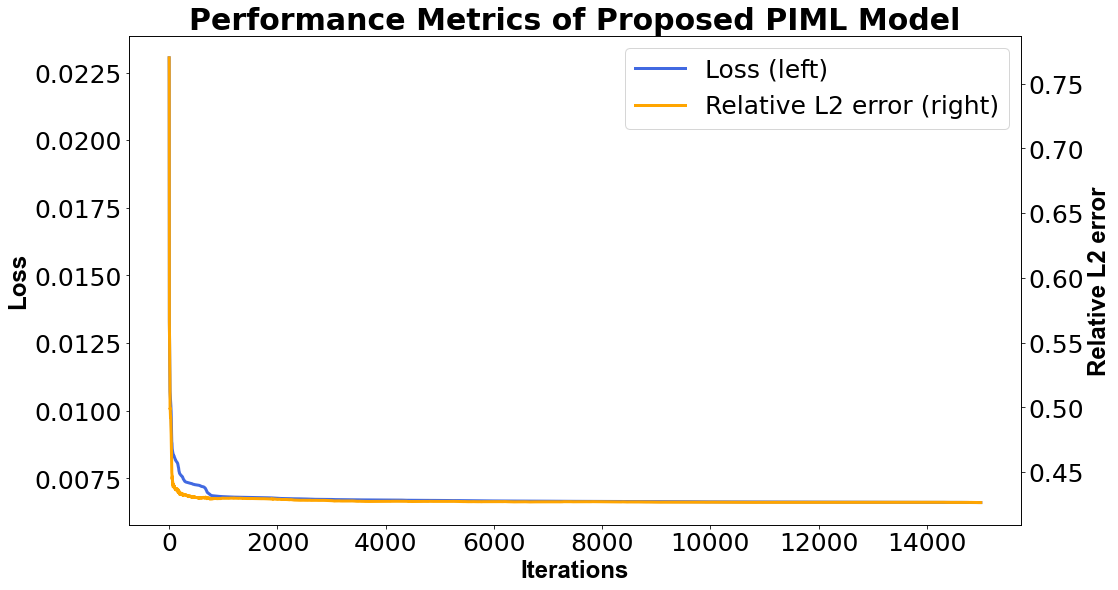

In [40]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [41]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.055156351686984975
MSE =  0.019314281421620002
RMSE =  0.13897583035053254
L2 relative error = 1.2061701038829438
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

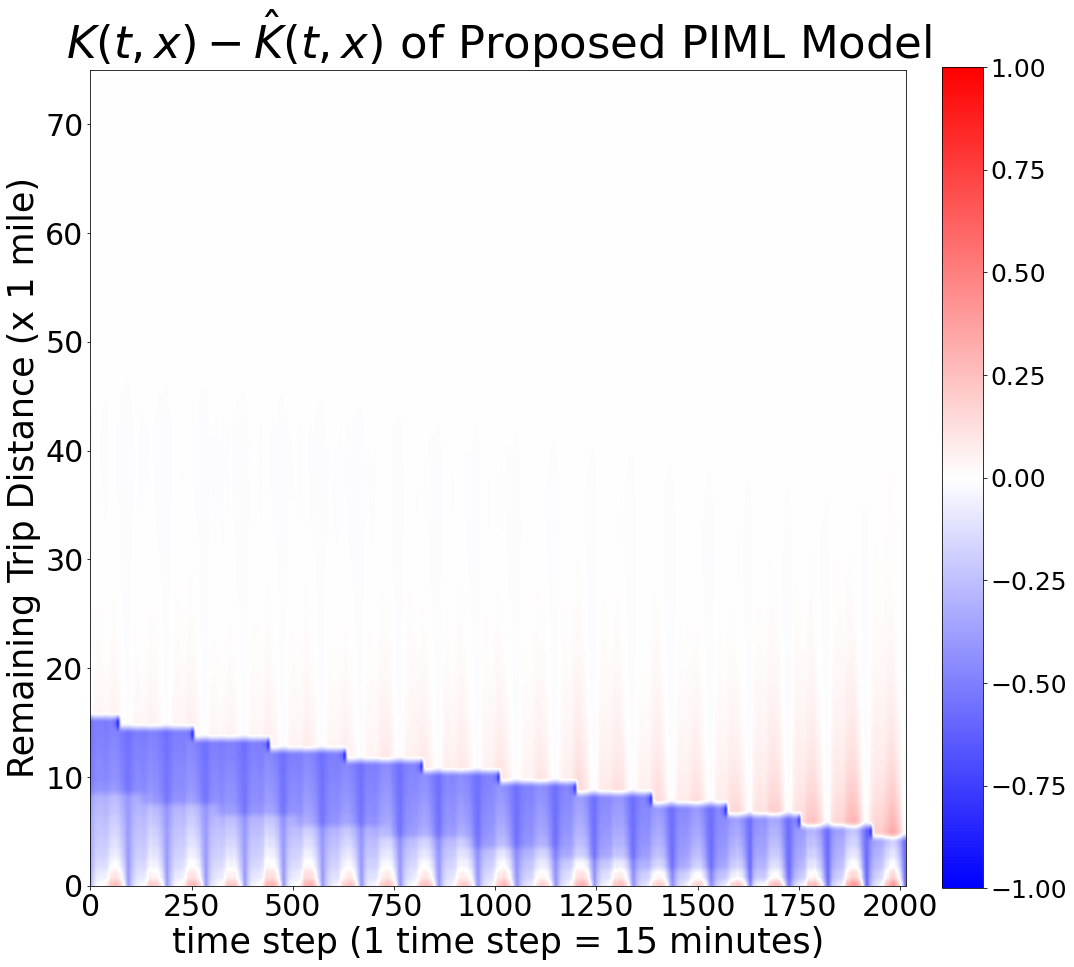

In [42]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

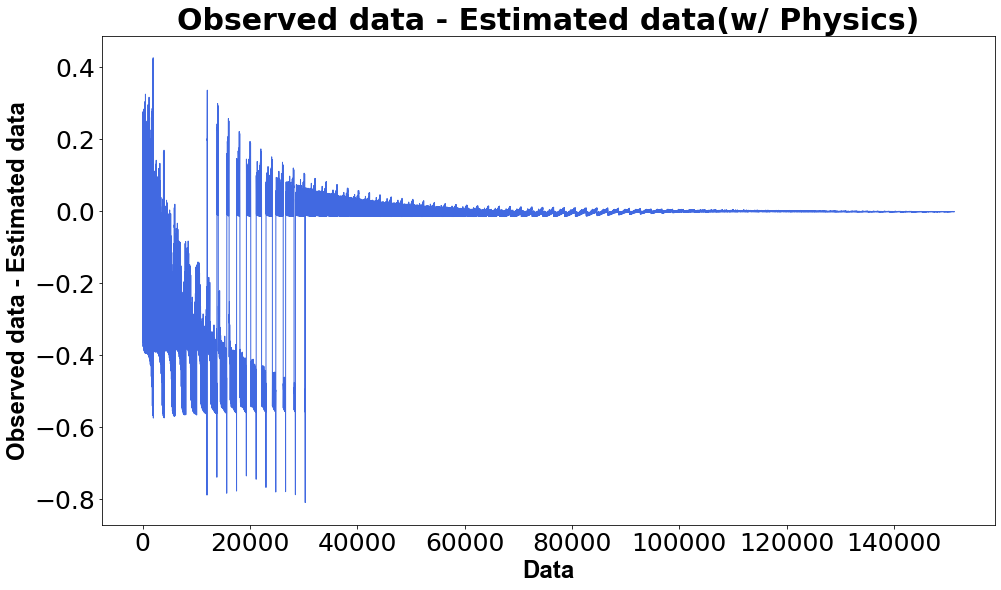

In [43]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

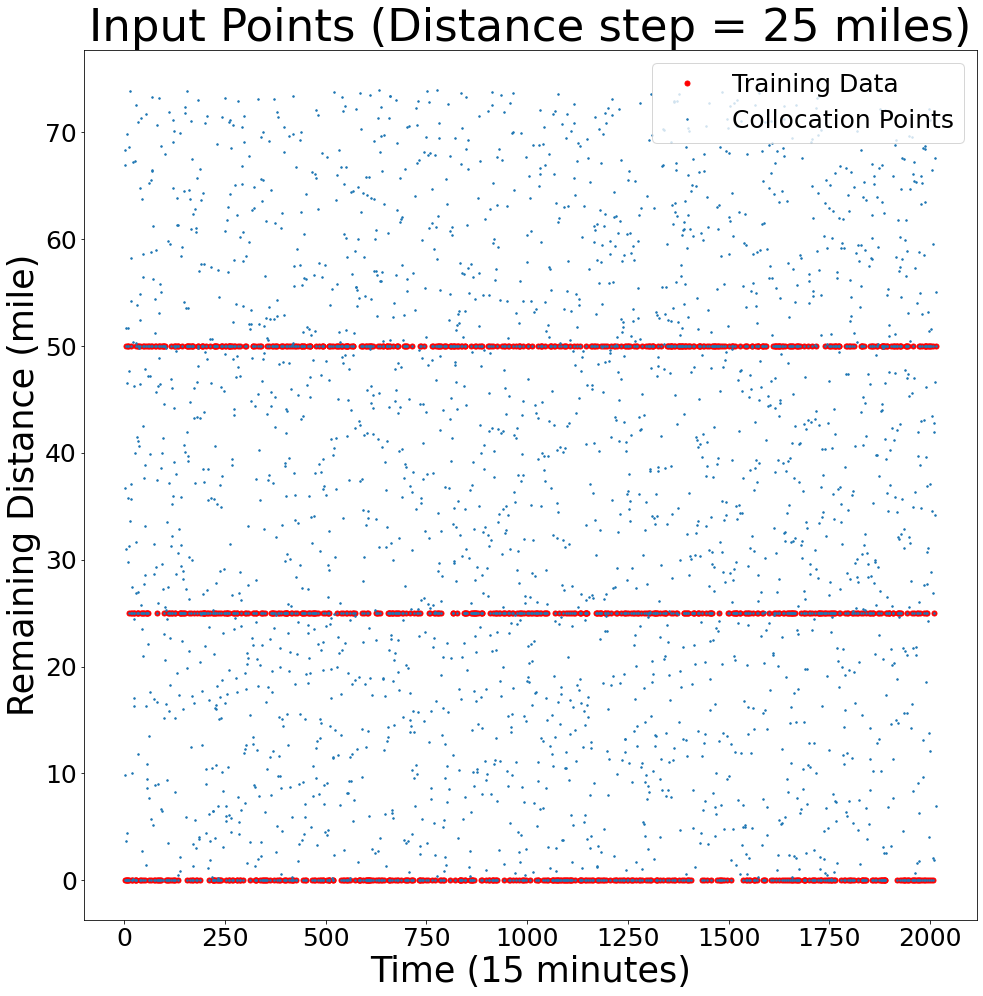

In [44]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 25 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

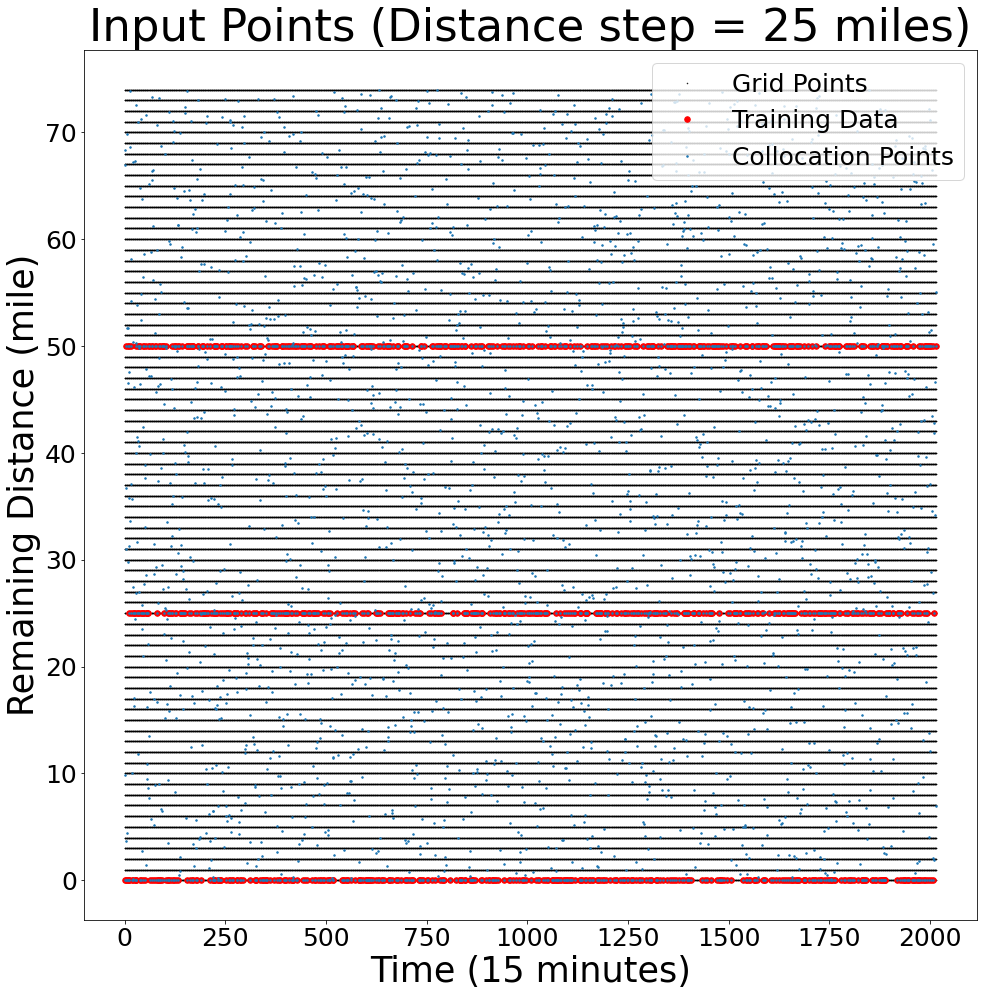

In [45]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 25 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


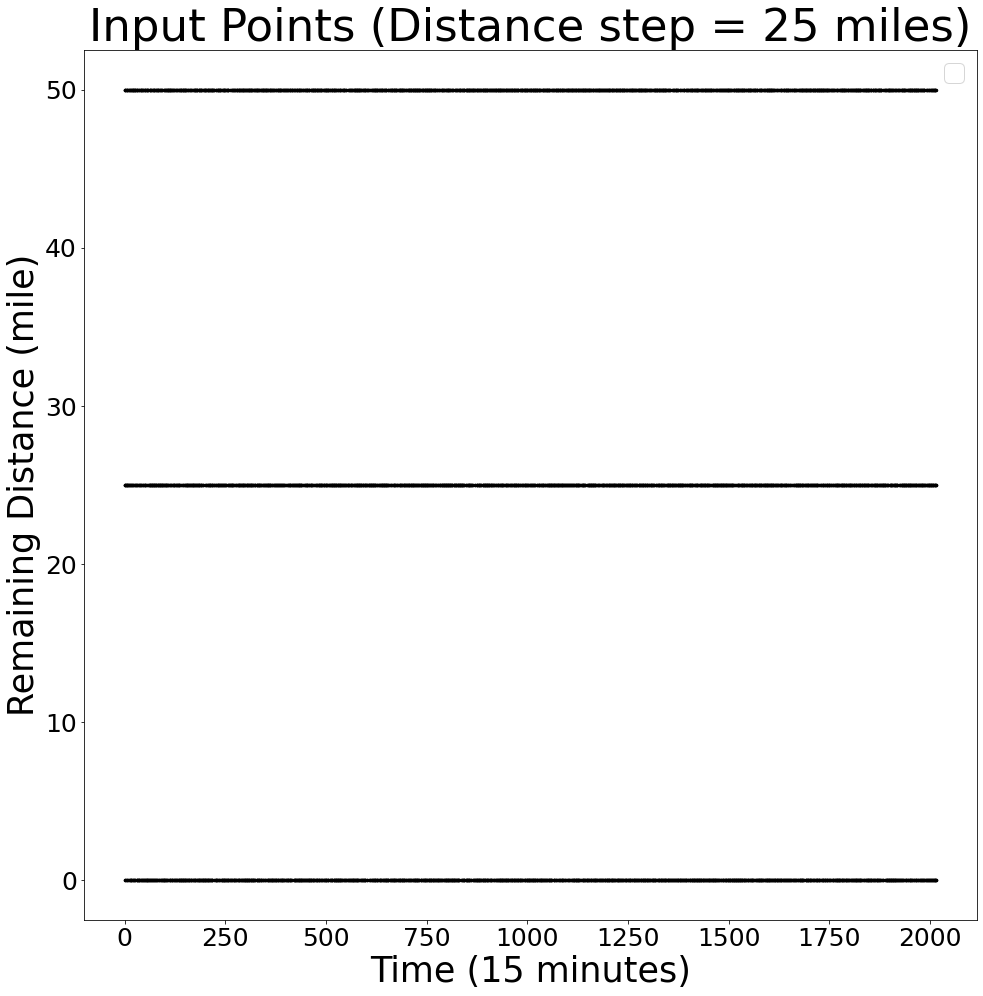

In [46]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_test[:,1]*multiplier_time, X_u_test[:,0]*multiplier_dist, 'o', color = 'black', markersize = 2.5)

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 25 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()